### **`Business Understanding`**

**Objective**: The primary objective of this project is to predict fluctuations in the U.S. Dollar Index (DXY) using historical prices of Bitcoin, crude oil, and gold, alongside other influential factors such as economic trends and temporal variables. Additionally, the project aims to utilize these predictions to calculate and assess portfolio risk, providing actionable insights for more informed investment strategies.

**Key Questions:**
1. What are the relationships between Bitcoin, crude oil, and gold prices, and how do they correlate with changes in the U.S. Dollar Index?
2.	To what extent do external features, such as holidays, weekdays, or the DXY itself, influence the accuracy and predictive power of the model?
3.	How can the predictive model be used to calculate and evaluate portfolio risk, helping investors optimize their asset allocation?
4.	What actionable insights can the predictive model offer for market forecasting and portfolio management strategies?

### **`Data Preparation`**

**Objective**: merging different datasets into one

#### **Separate Dataset Preprocessing**
- At the End of this stage we will have different cleaned DataFrames, ready for a left join By date.
    - Standardize column names
    - Proper Dtypes
    - Date properties (holiday, weekday) changed to binary
    - Ensured about date Integrity for all DFs

##### **Importation of Packages and  Reading CSV**

In [182]:
import pandas as pd
from dateutil import parser
from datetime import datetime
import holidays

In [183]:
oil_path = 'https://raw.githubusercontent.com/coderacheal/Inter-Market-Dynamics-Gold-Oil-Bitcoin-Dollar-Index/refs/heads/main/datasets/cleaned_oil.csv'
gold_path = 'https://raw.githubusercontent.com/coderacheal/Inter-Market-Dynamics-Gold-Oil-Bitcoin-Dollar-Index/refs/heads/main/datasets/cleaned_gold.csv'
btc_path = 'https://raw.githubusercontent.com/coderacheal/Inter-Market-Dynamics-Gold-Oil-Bitcoin-Dollar-Index/refs/heads/main/datasets/cleaned_btc.csv'
dxy_path = 'https://raw.githubusercontent.com/coderacheal/Inter-Market-Dynamics-Gold-Oil-Bitcoin-Dollar-Index/refs/heads/main/datasets/cleaned_dxy.csv'
date_path = 'https://raw.githubusercontent.com/coderacheal/Inter-Market-Dynamics-Gold-Oil-Bitcoin-Dollar-Index/refs/heads/main/datasets/date.csv'
holiday_path = 'https://raw.githubusercontent.com/coderacheal/Inter-Market-Dynamics-Gold-Oil-Bitcoin-Dollar-Index/refs/heads/main/datasets/holiday.csv'
# weekdays_path = 'https://raw.githubusercontent.com/coderacheal/Inter-Market-Dynamics-Gold-Oil-Bitcoin-Dollar-Index/refs/heads/main/datasets/weekday.csv'

In [184]:
df_oil = pd.read_csv(oil_path)
df_gold = pd.read_csv(gold_path)
df_dxy = pd.read_csv(dxy_path)
df_btc = pd.read_csv(btc_path)
df_date = pd.read_csv(date_path)
df_holiday = pd.read_csv(holiday_path)
# df_weekday = pd.read_csv(weekdays_path)


##### **Oil DataFrame Preprocessing**

In [185]:
df_oil.head()

,Date,oil_close,oil_open,oil_high,oil_low
0,2024-11-06,71.83,72.07,72.63,69.75
1,2024-11-05,71.99,71.62,72.67,71.29
2,2024-11-04,71.47,70.29,71.81,70.25
3,2024-11-01,69.49,70.44,71.45,69.32
4,2024-10-31,69.26,69.10,70.81,68.30


In [186]:
df_oil.dtypes

Date          object
oil_close    float64
oil_open     float64
oil_high     float64
oil_low      float64
dtype: object

In [187]:
# Convert Date to datetime
df_oil['Date'] = pd.to_datetime(df_oil['Date'])

In [188]:
df_oil.shape

(2858, 5)

In [189]:
# Check for start and end date
df_oil['Date'].min(), df_oil['Date'].max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2024-11-06 00:00:00'))

##### **Gold DataFrame Preprocessing**

In [190]:
df_gold.head()

,Date,gold_close,gold_open,gold_high,gold_low
0,2024-11-06,"2,668.00","2,754.40","2,758.70","2,660.75"
1,2024-11-05,"2,749.70","2,746.00","2,759.50","2,733.40"
2,2024-11-04,"2,746.20","2,743.50","2,757.50","2,739.40"
3,2024-11-01,"2,749.20","2,754.00","2,772.40","2,742.60"
4,2024-10-31,"2,749.30","2,799.10","2,801.20","2,741.80"


In [191]:
df_gold.dtypes

Date          object
gold_close    object
gold_open     object
gold_high     object
gold_low      object
dtype: object

In [192]:
# Convert Date to datetime
df_gold['Date'] = pd.to_datetime(df_gold['Date'])

In [193]:
# Covert Object to Float
for col in ["gold_close", "gold_open", "gold_high", "gold_low"]:
    df_gold[col] = df_gold[col].str.replace(',', '').astype(float)

In [194]:
df_gold.shape

(2568, 5)

In [195]:
# Check for start and end date
df_gold['Date'].min(), df_gold['Date'].max()

(Timestamp('2014-11-03 00:00:00'), Timestamp('2024-11-06 00:00:00'))

##### **BTC DataFrame Preprocessing**

In [196]:
df_btc.head()

,Unnamed: 0,Date,btc_open,btc_high,btc_low,btc_close
0,0,2024-10-21,69009.37,69408.10,66873.84,67525.97
1,1,2024-10-20,68364.18,69359.01,68105.72,69001.70
2,2,2024-10-19,68418.98,68668.01,68024.64,68362.73
3,3,2024-10-18,67419.11,68969.75,67177.82,68418.79
4,4,2024-10-17,67617.08,67912.21,66647.39,67399.84


In [197]:
df_btc.dtypes

Unnamed: 0      int64
Date           object
btc_open      float64
btc_high      float64
btc_low       float64
btc_close     float64
dtype: object

In [198]:
df_btc = df_btc.drop(columns=['Unnamed: 0'])

In [199]:
df_btc.shape

(3643, 5)

In [200]:
# Convert Date to datetime
df_btc['Date'] = pd.to_datetime(df_btc['Date'])

In [201]:
# Check for start and end date
df_gold['Date'].min(), df_gold['Date'].max()

(Timestamp('2014-11-03 00:00:00'), Timestamp('2024-11-06 00:00:00'))

##### **DXY DataFrame Preprocessing**

In [202]:
df_dxy.head()

,Date,dxy_close,dxy_open,dxy_high,dxy_low,Vol.,Change %
0,2024-11-06,105.16,103.70,105.44,103.70,NaN,1.68%
1,2024-11-05,103.42,103.91,103.96,103.37,NaN,-0.45%
2,2024-11-04,103.89,104.32,103.97,103.58,NaN,-0.37%
3,2024-11-01,104.28,103.86,104.35,103.68,NaN,0.29%
4,2024-10-31,103.98,104.08,104.22,103.82,NaN,-0.01%


In [203]:
# drop  vol, change columns
df_dxy = df_dxy.drop(columns=['Vol.', 'Change %'])

In [204]:
df_dxy.dtypes

Date          object
dxy_close    float64
dxy_open     float64
dxy_high     float64
dxy_low      float64
dtype: object

In [205]:
# Convert Date to datetime
df_dxy['Date'] = pd.to_datetime(df_dxy['Date'])

In [206]:
df_dxy.shape

(2832, 5)

In [207]:
# Check for start and end date
df_dxy['Date'].min(), df_dxy['Date'].max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2024-11-06 00:00:00'))

##### **Date DataFrame Preprocessing**

In [208]:
df_date.head()

,Unnamed: 0,Date,DoW,Month,Year
0,0,2014-11-01,Saturday,11,2014
1,1,2014-11-02,Sunday,11,2014
2,2,2014-11-03,Monday,11,2014
3,3,2014-11-04,Tuesday,11,2014
4,4,2014-11-05,Wednesday,11,2014


In [209]:
df_date = df_date.drop(columns=['Unnamed: 0'])

In [210]:
df_date['Date'] = pd.to_datetime(df_date['Date'])

In [211]:
df_date.shape

(3653, 4)

In [212]:
df_date['Date'].min(), df_date['Date'].max()

(Timestamp('2014-11-01 00:00:00'), Timestamp('2024-10-31 00:00:00'))

##### **Holiday DataFrame Preprocessing**

In [213]:
df_holiday = df_holiday[['Date','Title']]

In [214]:
df_holiday['Date'] = pd.to_datetime(df_holiday['Date'])

In [215]:
df_holiday.dtypes

Date     datetime64[ns]
Title            object
dtype: object

##### **Weekday DataFrame Creating**

In [216]:
# Define the date range (10 years)
start_date = datetime(2014, 1, 1)  # Start of the range
end_date = datetime(2024, 11, 6)    # End of the range
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

In [217]:
# Create a DataFrame with the date range
df_weekday = pd.DataFrame(date_range, columns=["Date"])

# Add a column indicating whether each date is a weekday
df_weekday["is_weekday"] = df_weekday["Date"].dt.weekday < 5  # Monday=0, Sunday=6

# Initialize the holidays for a specific country (e.g., United States)
us_holidays = holidays.UnitedStates(years=range(2014, 2025))

# Add a column indicating whether each date is a holiday
df_weekday["is_holiday"] = df_weekday["Date"].dt.date.isin(us_holidays)


In [218]:
df_weekday["is_weekday"] = df_weekday["is_weekday"].astype(int)
df_weekday["is_holiday"] = df_weekday["is_holiday"].astype(int)

In [219]:
df_weekday.tail()

,Date,is_weekday,is_holiday
3958,2024-11-02,0,0
3959,2024-11-03,0,0
3960,2024-11-04,1,0
3961,2024-11-05,1,0
3962,2024-11-06,1,0


#### **Joining Stage**
- The Final Table
    - Daily Open, High, Low, Close Prices of commodities 
    - Daily Open, High, Low, Close Prices of Dollar Index
    - Date properties (holiday, weekday)
    - Proper Dtypes

In [220]:
# merge all dataframes
df = df_date \
    .merge(df_btc, on='Date', how='left') \
    .merge(df_oil, on='Date', how='left') \
    .merge(df_gold, on='Date', how='left') \
    .merge(df_dxy, on='Date', how='left') \
    .merge(df_weekday, on='Date', how='left') \
    .merge(df_holiday, on='Date', how='left')

In [221]:
df.head(10)

,Date,DoW,Month,Year,btc_open,btc_high,btc_low,btc_close,oil_close,oil_open,oil_high,oil_low,gold_close,gold_open,gold_high,gold_low,dxy_close,dxy_open,dxy_high,dxy_low,is_weekday,is_holiday,Title
0,2014-11-01,Saturday,11,2014,338.65,340.53,321.05,325.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,2014-11-02,Sunday,11,2014,326.08,329.05,320.63,325.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
2,2014-11-03,Monday,11,2014,325.57,334.00,325.48,327.55,78.78,80.59,80.98,78.08,1169.8,1171.1,1173.4,1161.0,87.31,87.08,87.41,87.02,1,0,NaN
3,2014-11-04,Tuesday,11,2014,327.16,331.77,325.08,330.49,77.19,78.22,78.41,75.84,1167.7,1164.6,1175.0,1163.4,86.98,87.25,87.30,86.88,1,0,NaN
4,2014-11-05,Wednesday,11,2014,330.68,343.37,330.68,339.49,78.68,77.36,79.35,76.46,1145.7,1168.4,1169.3,1137.1,87.44,87.01,87.61,86.94,1,0,NaN
5,2014-11-06,Thursday,11,2014,339.46,352.97,338.42,349.29,77.91,78.87,78.98,77.12,1142.6,1140.8,1149.0,1137.2,88.01,87.43,88.15,87.13,1,0,NaN
6,2014-11-07,Friday,11,2014,349.82,352.73,341.78,342.42,78.65,77.86,79.41,77.47,1169.8,1141.2,1179.0,1130.4,87.64,88.06,88.19,87.47,1,0,NaN
7,2014-11-08,Saturday,11,2014,342.15,347.03,342.15,345.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
8,2014-11-09,Sunday,11,2014,345.38,363.63,344.26,363.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
9,2014-11-10,Monday,11,2014,362.27,374.82,357.56,366.92,77.40,78.50,79.85,77.13,1159.8,1176.8,1177.5,1146.7,87.81,87.43,87.83,87.22,1,0,NaN


In [222]:
df = df.sort_values(by='Date', ascending=False)

### **`Data Understanding`**

In [223]:
# Descriptive Analytics Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

# Time Series Analysis Packages
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning Packages
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor , XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import shap
from sklearn.inspection import PartialDependenceDisplay



# Data Manipulations & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preparation
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.decomposition import PCA

# from imblearn.pipeline import Pipeline as imbpipeline
# from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

#Model Persistance
import joblib


#Utilities
import warnings
sns.set_style('darkgrid')
import os

In [224]:
pd.set_option('display.max_columns' , None)
pd.set_option('display.max_rows' , None)

In [225]:
# # Not Necessary
# # Get the current directory of the script
# current_dir = os.getcwd()

# # Go back one folder and then to 'datasets'
# csv_path = os.path.join(current_dir, "..", "datasets", "final_dataset.csv")

# # Normalize the path for platform independence
# csv_path = os.path.normpath(csv_path)
# df = pd.read_csv(csv_path)
# df.head()

#### **Data Cleaning**

In [226]:
df.columns

Index(['Date', 'DoW', 'Month', 'Year', 'btc_open', 'btc_high', 'btc_low',
       'btc_close', 'oil_close', 'oil_open', 'oil_high', 'oil_low',
       'gold_close', 'gold_open', 'gold_high', 'gold_low', 'dxy_close',
       'dxy_open', 'dxy_high', 'dxy_low', 'is_weekday', 'is_holiday', 'Title'],
      dtype='object')

In [227]:
df.dtypes

Date          datetime64[ns]
DoW                   object
Month                  int64
Year                   int64
btc_open             float64
btc_high             float64
btc_low              float64
btc_close            float64
oil_close            float64
oil_open             float64
oil_high             float64
oil_low              float64
gold_close           float64
gold_open            float64
gold_high            float64
gold_low             float64
dxy_close            float64
dxy_open             float64
dxy_high             float64
dxy_low              float64
is_weekday             int64
is_holiday             int64
Title                 object
dtype: object

In [228]:
df.isna().sum()

Date             0
DoW              0
Month            0
Year             0
btc_open        10
btc_high        10
btc_low         10
btc_close       10
oil_close     1016
oil_open      1016
oil_high      1016
oil_low       1016
gold_close    1089
gold_open     1089
gold_high     1089
gold_low      1089
dxy_close     1043
dxy_open      1043
dxy_high      1043
dxy_low       1043
is_weekday       0
is_holiday       0
Title         3549
dtype: int64

In [229]:
df['Date'].min(), df['Date'].max()

(Timestamp('2014-11-01 00:00:00'), Timestamp('2024-10-31 00:00:00'))

In [230]:
##### Rearranging columns for easier analysis
new_column_order = ['Date', 'DoW', 'Month', 'Year', 
                    'btc_open', 'btc_high', 'btc_low','btc_close',
                    'oil_open', 'oil_high', 'oil_low', 'oil_close', 
                    'gold_open', 'gold_high', 'gold_low', 'gold_close',
                    'dxy_open', 'dxy_high', 'dxy_low', 'dxy_close', 
                    'is_holiday', 'is_weekday', 'Title']

df = df[new_column_order]

In [231]:
df.rename(columns={'Title': 'Holiday_Name'}, inplace=True)

In [232]:
df.drop(columns=['Holiday_Name'], inplace=True)

In [233]:
df.head()

,Date,DoW,Month,Year,btc_open,btc_high,btc_low,btc_close,oil_open,oil_high,oil_low,oil_close,gold_open,gold_high,gold_low,gold_close,dxy_open,dxy_high,dxy_low,dxy_close,is_holiday,is_weekday
3652,2024-10-31,Thursday,10,2024,NaN,NaN,NaN,NaN,69.10,70.81,68.30,69.26,2799.1,2801.2,2741.8,2749.3,104.08,104.22,103.82,103.98,0,1
3651,2024-10-30,Wednesday,10,2024,NaN,NaN,NaN,NaN,67.47,69.17,67.28,68.61,2786.9,2801.8,2782.4,2800.8,104.25,104.44,103.98,103.99,0,1
3650,2024-10-29,Tuesday,10,2024,NaN,NaN,NaN,NaN,68.02,68.52,66.72,67.21,2741.9,2773.2,2741.9,2768.8,104.31,104.64,104.21,104.32,0,1
3649,2024-10-28,Monday,10,2024,NaN,NaN,NaN,NaN,68.98,69.00,66.92,67.38,2749.2,2758.3,2736.9,2755.9,104.32,104.57,104.12,104.32,0,1
3648,2024-10-27,Sunday,10,2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


#### **Exploratory Data Analysis**

In [234]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,3653,2019-11-01 00:00:00,2014-11-01 00:00:00,2017-05-02 00:00:00,2019-11-01 00:00:00,2022-05-02 00:00:00,2024-10-31 00:00:00,NaN
Month,3653.0,6.52231,1.0,4.0,7.0,10.0,12.0,3.449345
Year,3653.0,2019.333425,2014.0,2017.0,2019.0,2022.0,2024.0,2.897193
btc_open,3643.0,18449.732976,176.9,1319.855,9314.13,29848.585,73079.38,20039.91454
btc_high,3643.0,18865.656794,211.73,1339.595,9466.35,30391.11,73750.07,20480.738577
btc_low,3643.0,18008.72678,171.51,1315.065,9149.39,29307.625,71334.09,19563.811246
btc_close,3643.0,18467.017137,178.1,1334.84,9316.63,29859.74,73083.5,20052.330675
oil_open,2637.0,61.894638,18.01,48.79,59.65,74.18,120.66,17.514253
oil_high,2637.0,62.903367,19.66,49.46,60.5,75.31,126.42,17.76924
oil_low,2637.0,60.817175,6.5,47.9,58.75,73.01,118.52,17.228812


##### **Distribution Analysis**

[]

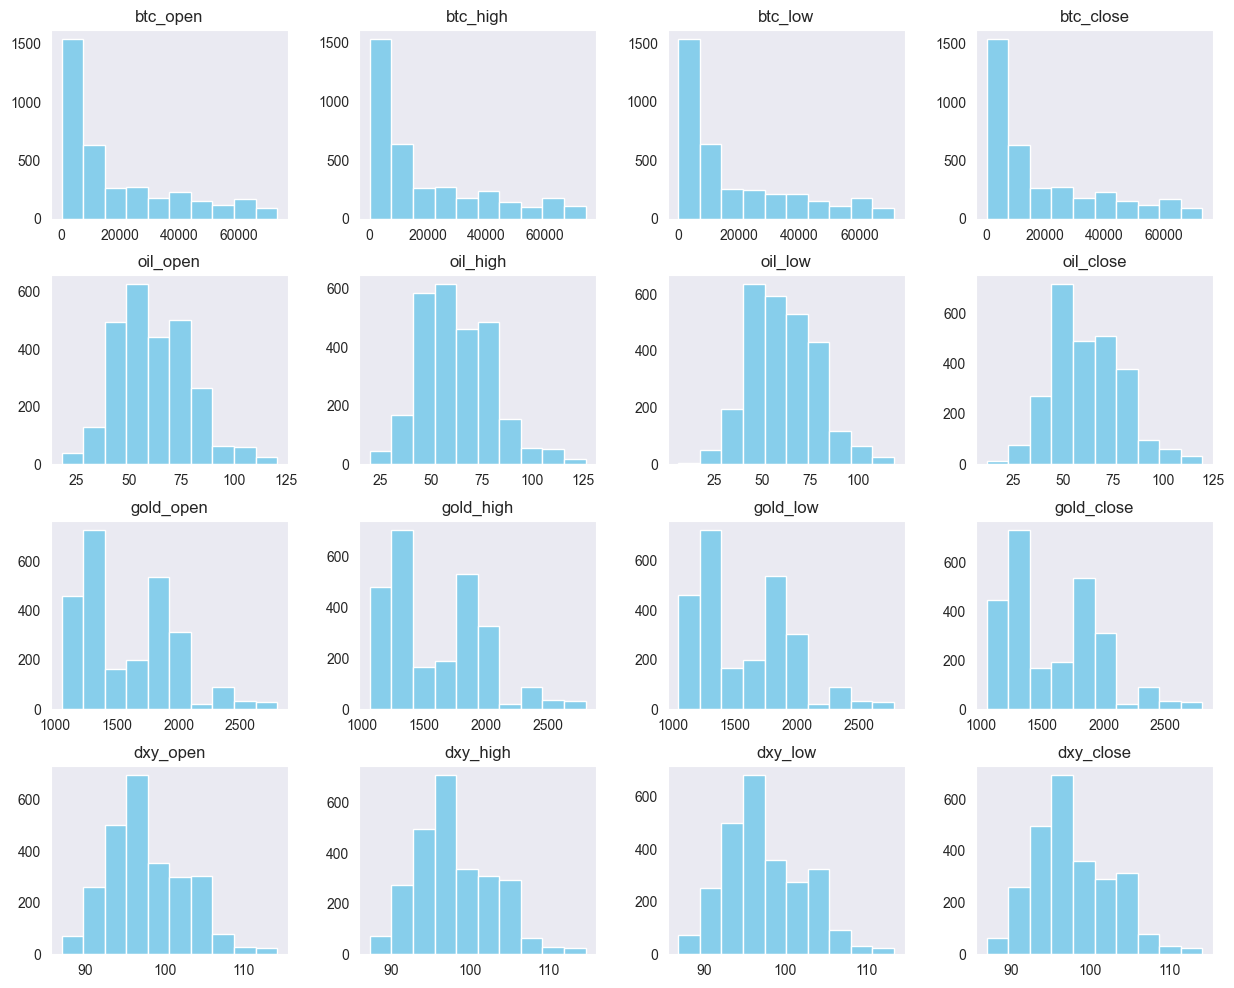

In [235]:
df.drop(columns=['Date', 'Month', 'Year', 'is_holiday', 'is_weekday']).hist(grid=False, color='skyblue', figsize=(15, 12) )
plt.plot()

##### **Correlation Analysis**

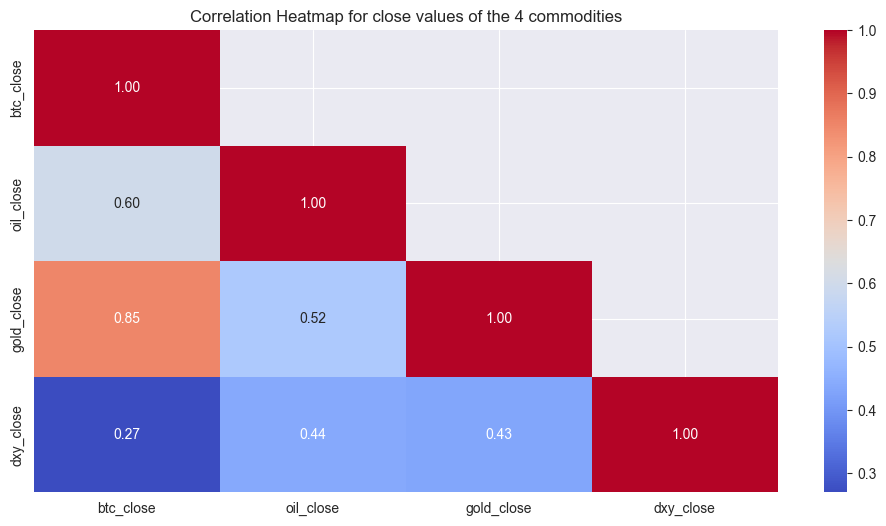

In [236]:
correlation_matrix = df[['btc_close', 'oil_close', 'gold_close', 'dxy_close']].corr().round(2)

# Modify the mask to exclude the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Plot the heatmap with the modified mask to include the diagonal
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap for close values of the 4 commodities")
plt.show()

##### **Time Series Analysis**

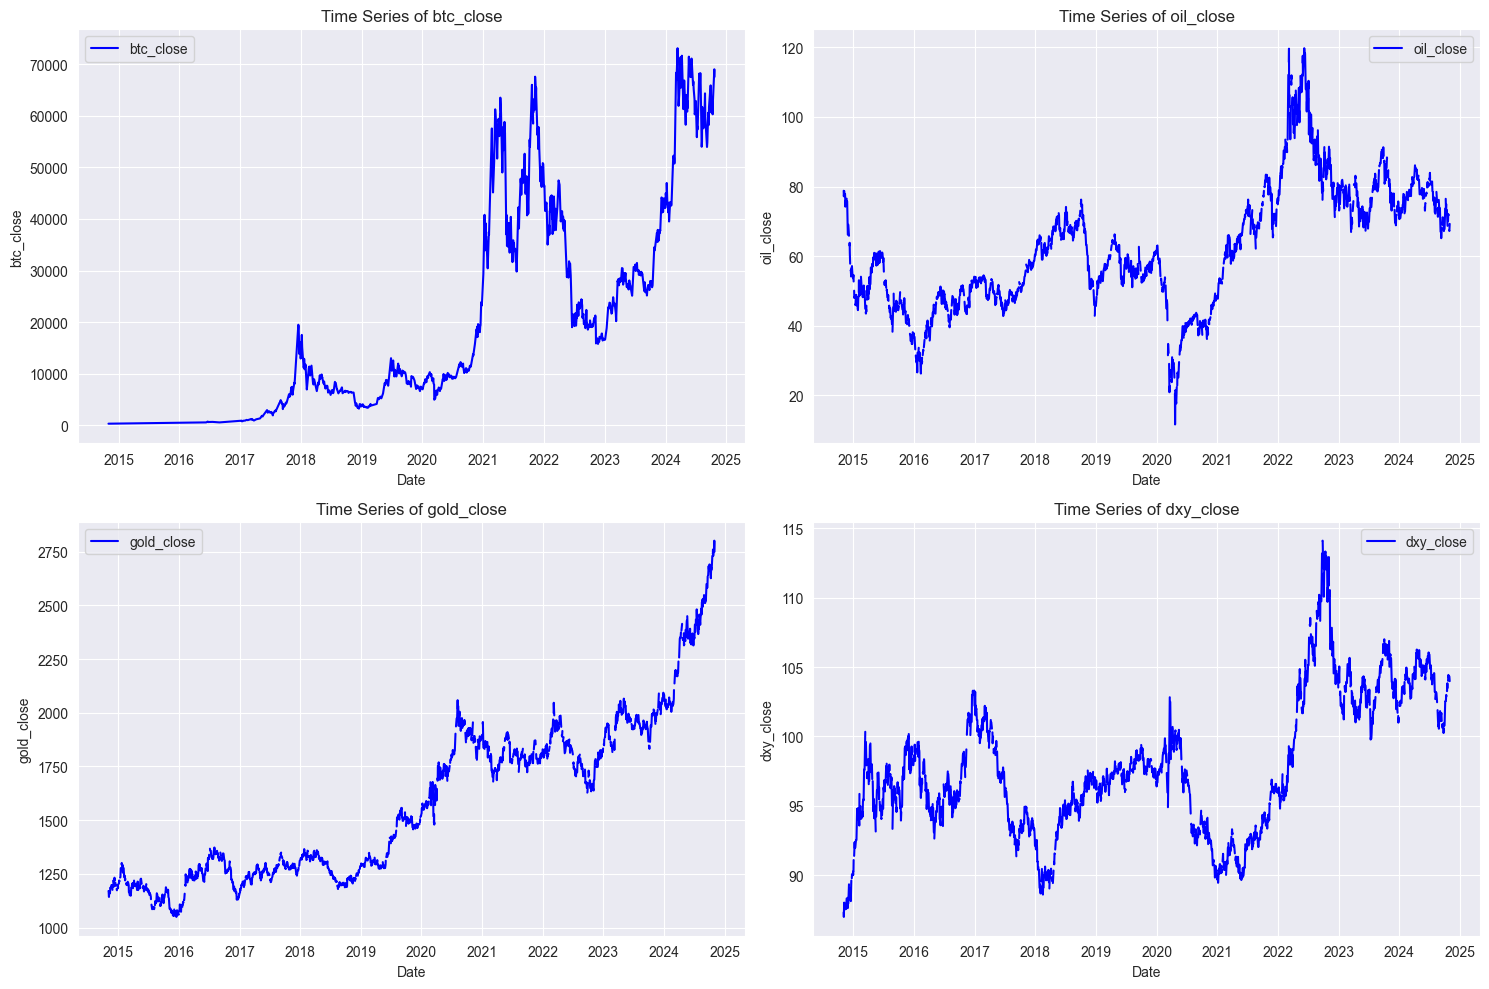

In [237]:
# Set Date as the index for time series analysis
df.set_index('Date', inplace=True)

# Ensure the dataset is sorted by date in ascending order
df = df.sort_index(ascending=True)


# List of variables to analyze
variables = ['btc_close', 'oil_close', 'gold_close', 'dxy_close']

# Plot time series of each variable
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables):
    plt.subplot(2, 2, i+1)
    plt.plot(df[var], label=var, color='blue')
    plt.title(f"Time Series of {var}")
    plt.xlabel("Date")
    plt.ylabel(var)
    plt.legend()

plt.tight_layout()
plt.show()

/var/folders/by/fqpfnqw528347myb5cyy33x80000gn/T/ipykernel_55516/757868538.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_commodity['Date'] = df.index  # Reset Date from index
/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/.venv/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================

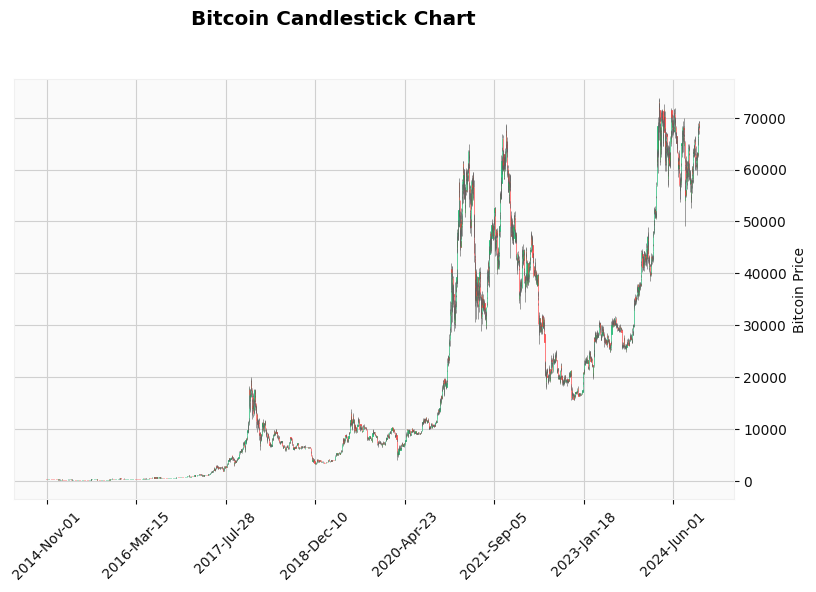

/var/folders/by/fqpfnqw528347myb5cyy33x80000gn/T/ipykernel_55516/757868538.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_commodity['Date'] = df.index  # Reset Date from index
/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/.venv/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================

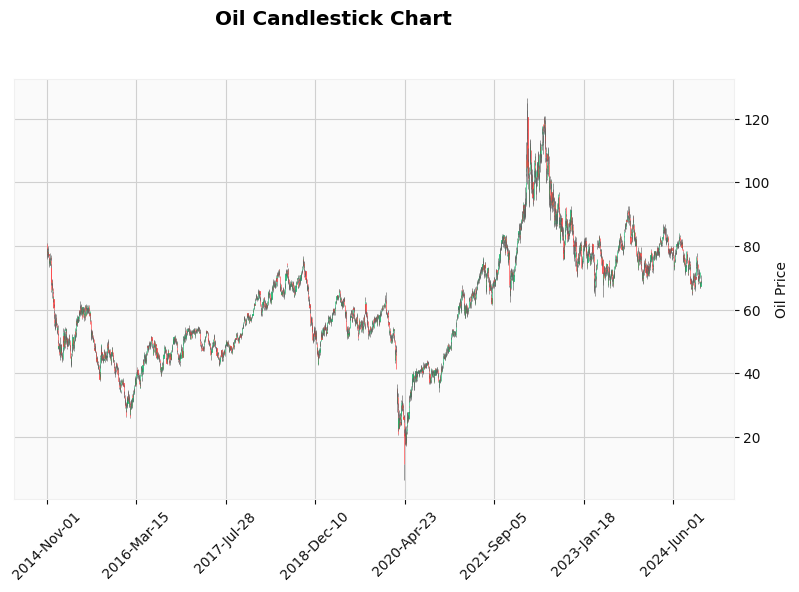

/var/folders/by/fqpfnqw528347myb5cyy33x80000gn/T/ipykernel_55516/757868538.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_commodity['Date'] = df.index  # Reset Date from index
/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/.venv/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================

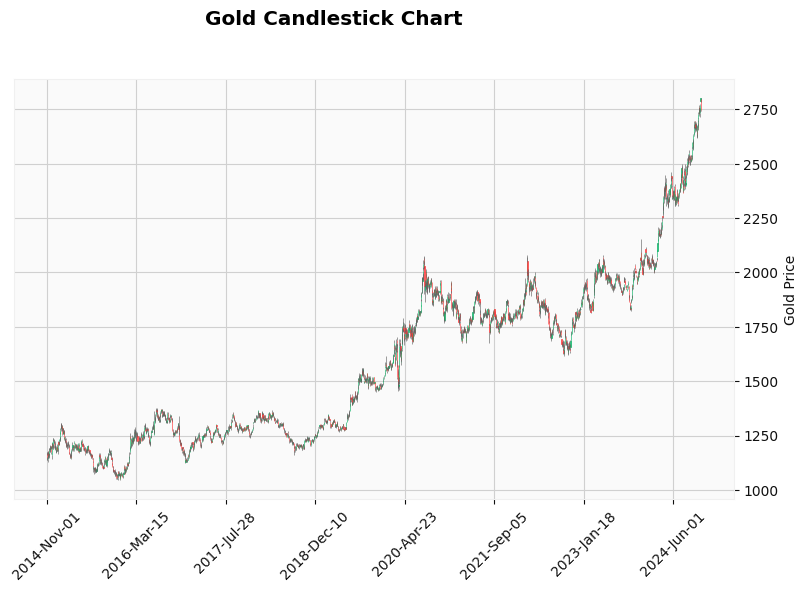

/var/folders/by/fqpfnqw528347myb5cyy33x80000gn/T/ipykernel_55516/757868538.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_commodity['Date'] = df.index  # Reset Date from index
/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/.venv/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================

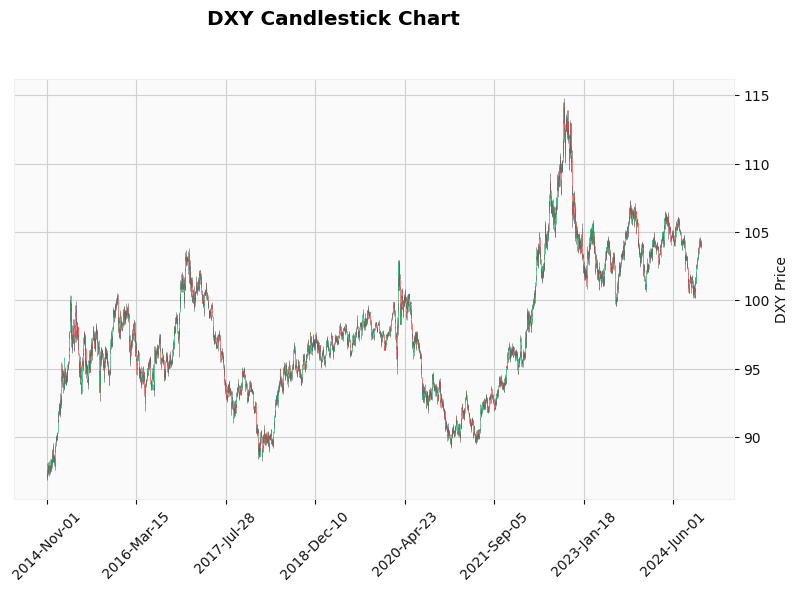

In [238]:
# List of commodities and their relevant columns
commodities = {
    'Bitcoin': ['btc_open', 'btc_high', 'btc_low', 'btc_close'],
    'Oil': ['oil_open', 'oil_high', 'oil_low', 'oil_close'],
    'Gold': ['gold_open', 'gold_high', 'gold_low', 'gold_close'],
    'DXY': ['dxy_open', 'dxy_high', 'dxy_low', 'dxy_close']
}

# Plot candlestick charts for each commodity
for name, columns in commodities.items():
    # Subset the data for the specific commodity
    df_commodity = df[columns]
    df_commodity.columns = ['Open', 'High', 'Low', 'Close']  # Rename for mplfinance compatibility
    df_commodity['Date'] = df.index  # Reset Date from index
    df_commodity.set_index('Date', inplace=True)
    
    # Generate the candlestick chart
    mpf.plot(
        df_commodity,
        type='candle',
        title=f'{name} Candlestick Chart',
        style='yahoo',
        ylabel=f'{name} Price',
        figsize=(10, 6)
    )

##### **Addictive and Multiplicative Decompositions**

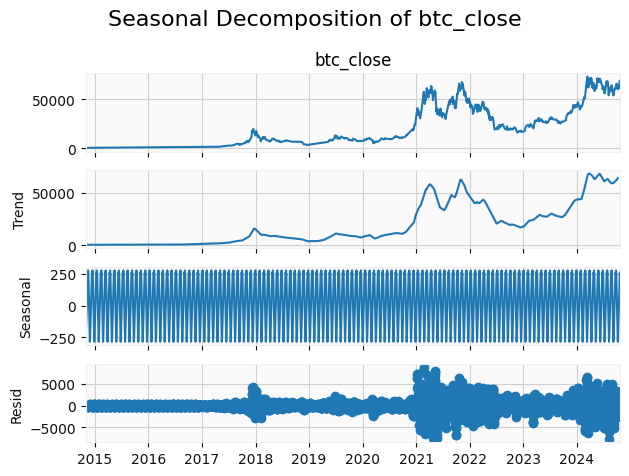

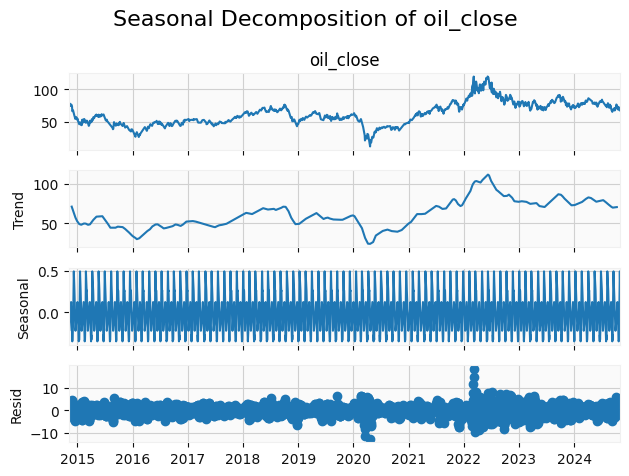

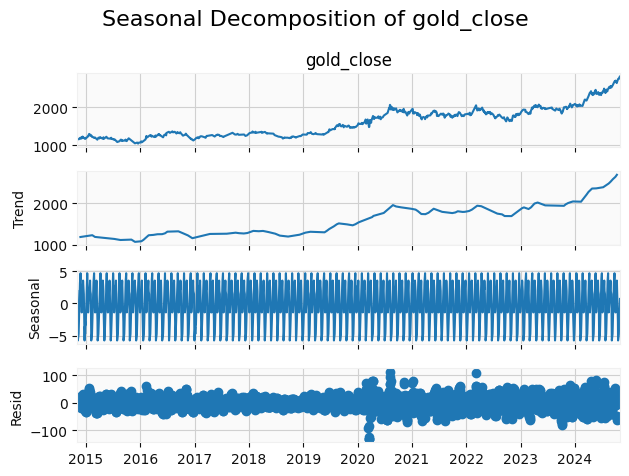

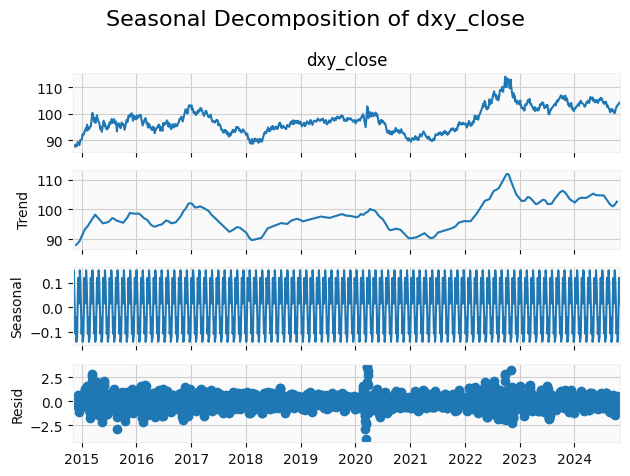

In [239]:
for variable in variables:
    decomposition = seasonal_decompose(df[variable].dropna(), model='additive', period=30)
    fig = decomposition.plot()
    fig.suptitle("") 
    plt.subplots_adjust(top=0.85) 
    plt.gcf().text(0.5, 0.95, f"Seasonal Decomposition of {variable}", fontsize=16, ha='center') 
    plt.show()

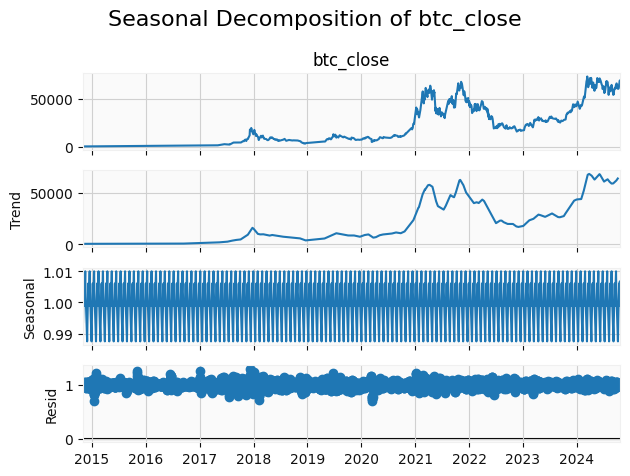

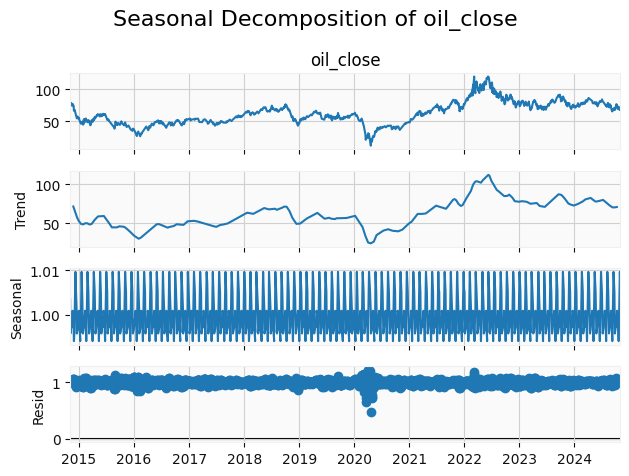

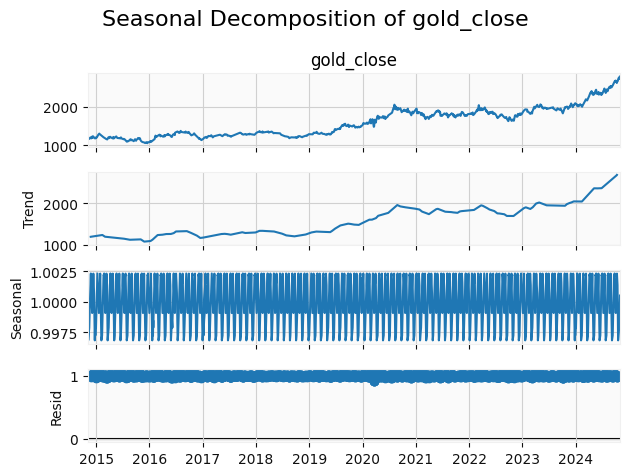

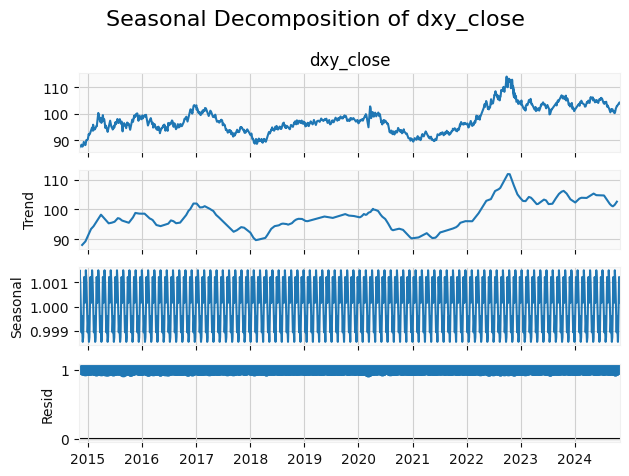

In [240]:
for variable in variables:
    decomposition = seasonal_decompose(df[variable].dropna(), model='multiplicative', period=30)
    fig = decomposition.plot()
    fig.suptitle("") 
    plt.subplots_adjust(top=0.85)  
    plt.gcf().text(0.5, 0.95, f"Seasonal Decomposition of {variable}", fontsize=16, ha='center')  
    plt.show()

##### **Outlier Analysis**

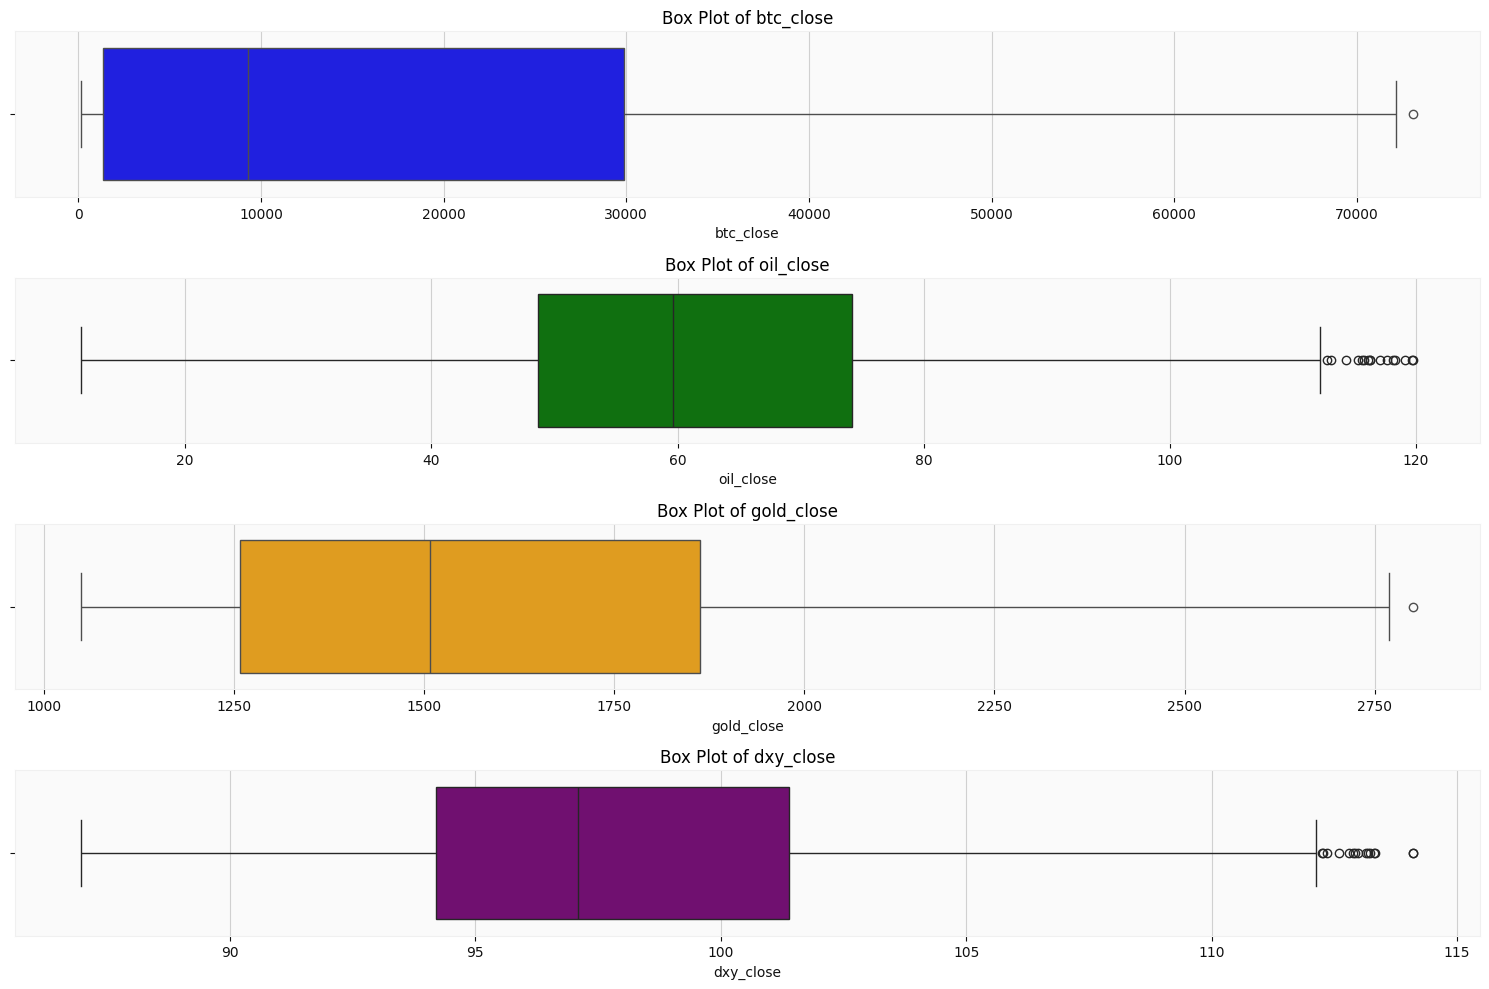

In [241]:
# List of columns to create boxplots for
variables = ['btc_close', 'oil_close', 'gold_close', 'dxy_close']
colors = ['blue', 'green', 'orange', 'purple']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 10), sharex=False)

# Generate horizontal boxplots for each variable
for i, var in enumerate(variables):
    sns.boxplot(x=df[var], ax=axes[i], orient='h', color=colors[i])
    axes[i].set_title(f"Box Plot of {var}")
    axes[i].set_xlabel(var)

# Adjust layout
plt.tight_layout()
plt.show()

### **`Feature Engineering`**

##### **Imputation missing values using Linear Interpolation**
- Gold, oil, dxy related Columns don't have missing values, unless it's a holiday or weekend.
- For BTC we don't have null values except 1st 10 rows

**Decision:** using Linear interploation for imputing null values 

In [242]:
df.isna().sum()

DoW              0
Month            0
Year             0
btc_open        10
btc_high        10
btc_low         10
btc_close       10
oil_open      1016
oil_high      1016
oil_low       1016
oil_close     1016
gold_open     1089
gold_high     1089
gold_low      1089
gold_close    1089
dxy_open      1043
dxy_high      1043
dxy_low       1043
dxy_close     1043
is_holiday       0
is_weekday       0
dtype: int64

In [243]:
# Imputing missing values in the oil, gold, and dollar data with interpolation
cols = ['btc_open', 'btc_high', 'btc_low', 'btc_close',
        'oil_open', 'oil_high', 'oil_low', 'oil_close',
         'gold_open', 'gold_high', 'gold_low', 'gold_close',
        'dxy_close', 'dxy_open', 'dxy_high', 'dxy_low']

df[cols] = df[cols].interpolate(method='linear', axis=0)

In [244]:
df.isna().sum()

DoW           0
Month         0
Year          0
btc_open      0
btc_high      0
btc_low       0
btc_close     0
oil_open      2
oil_high      2
oil_low       2
oil_close     2
gold_open     2
gold_high     2
gold_low      2
gold_close    2
dxy_open      2
dxy_high      2
dxy_low       2
dxy_close     2
is_holiday    0
is_weekday    0
dtype: int64

In [245]:
df.head(15)

,DoW,Month,Year,btc_open,btc_high,btc_low,btc_close,oil_open,oil_high,oil_low,oil_close,gold_open,gold_high,gold_low,gold_close,dxy_open,dxy_high,dxy_low,dxy_close,is_holiday,is_weekday
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-01,Saturday,11,2014,338.65,340.53,321.05,325.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2014-11-02,Sunday,11,2014,326.08,329.05,320.63,325.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2014-11-03,Monday,11,2014,325.57,334.00,325.48,327.55,80.590000,80.980000,78.080000,78.780000,1171.100000,1173.400000,1161.000000,1169.800000,87.080000,87.41,87.020000,87.310000,0,1
2014-11-04,Tuesday,11,2014,327.16,331.77,325.08,330.49,78.220000,78.410000,75.840000,77.190000,1164.600000,1175.000000,1163.400000,1167.700000,87.250000,87.30,86.880000,86.980000,0,1
2014-11-05,Wednesday,11,2014,330.68,343.37,330.68,339.49,77.360000,79.350000,76.460000,78.680000,1168.400000,1169.300000,1137.100000,1145.700000,87.010000,87.61,86.940000,87.440000,0,1
2014-11-06,Thursday,11,2014,339.46,352.97,338.42,349.29,78.870000,78.980000,77.120000,77.910000,1140.800000,1149.000000,1137.200000,1142.600000,87.430000,88.15,87.130000,88.010000,0,1
2014-11-07,Friday,11,2014,349.82,352.73,341.78,342.42,77.860000,79.410000,77.470000,78.650000,1141.200000,1179.000000,1130.400000,1169.800000,88.060000,88.19,87.470000,87.640000,0,1
2014-11-08,Saturday,11,2014,342.15,347.03,342.15,345.49,78.073333,79.556667,77.356667,78.233333,1153.066667,1178.500000,1135.833333,1166.466667,87.850000,88.07,87.386667,87.696667,0,0
2014-11-09,Sunday,11,2014,345.38,363.63,344.26,363.26,78.286667,79.703333,77.243333,77.816667,1164.933333,1178.000000,1141.266667,1163.133333,87.640000,87.95,87.303333,87.753333,0,0


#### **Creating weekly and monthly moving averages Based on Close Prices**
- {asset}_weekly_avg
- {asset}_monthly_avg

In [246]:
## Running Averages for open and close data

# List of price columns
price_cols = ['btc_close', 'oil_close', 'gold_close', 'dxy_close']

# Calculate running weekly and monthly averages
for asset in price_cols:
    df[f'{asset}_weekly_avg'] = df[asset].rolling(window=7, min_periods=1).mean()
    df[f'{asset}_monthly_avg'] = df[asset].rolling(window=30, min_periods=1).mean()

#### **Creating weekly and monthly percentage change in moving averages**
- {asset}_weekly_avg_pct_change
- {asset}_monthly_avg_pct_change

In [247]:
# Calculate rolling avg of daily percentage changes over 7-day and 30-day windows

for asset in price_cols:
    df[f'{asset}_weekly_avg_pct_change'] = df[f'{asset}_weekly_avg'].pct_change() * 100
    df[f'{asset}_monthly_avg_pct_change'] = df[f'{asset}_monthly_avg'].pct_change() * 100

#### **Creating Daily percentage changes for all 4 commodities**
- {asset}_Daily_ocpercentage --> change open and close
- {asset}_Daily_max_percentage --> change open and high
- {asset}_Daily_min_percentage --> change open and low

In [248]:
# Asset categories and their respective price types
assets = {
    'btc': ['btc_open', 'btc_close', 'btc_high', 'btc_low'],
    'oil': ['oil_open', 'oil_close', 'oil_high', 'oil_low'],
    'gold': ['gold_open', 'gold_close', 'gold_high', 'gold_low'],
    'dxy': ['dxy_open', 'dxy_close', 'dxy_high', 'dxy_low']
}

# Calculate daily percentage changes
for asset, cols in assets.items():
    open_col, close_col, high_col, low_col = cols
    df[f'{asset}_Daily_ocpercentage'] = ((df[close_col] - df[open_col]) / df[open_col] * 100)
    df[f'{asset}_Daily_max_percentage'] = ((df[high_col] - df[open_col]) / df[open_col] * 100)
    df[f'{asset}_Daily_min_percentage'] = ((df[low_col] - df[open_col]) / df[open_col] * 100)

#### **Creating Intraday Volatility**
- {asset}_intraday_volatility --> (difference high and low) / close

In [250]:
# Calculate intraday volatility as the percentage difference between high and low prices
assets = ['btc', 'oil', 'gold', 'dxy']  

for asset in assets:
    df[f'{asset}_intraday_volatility'] = ((df[f'{asset}_high'] - df[f'{asset}_low']) / df[f'{asset}_close']) * 100

#### **Creating day by day percentage change**
- {asset}_daily_percentage --> percentage difference between today close and yesterday close

In [251]:
# Calculate rolling volatility of daily percentage changes over 7-day and 30-day windows

for asset in assets:
    # Daily percentage change
    df[f'{asset}_daily_percentage'] = df[f'{asset}_close'].pct_change() * 100

In [252]:
df['gold_daily_percentage'].head(10)

Date
2014-11-01         NaN
2014-11-02         NaN
2014-11-03         NaN
2014-11-04   -0.179518
2014-11-05   -1.884046
2014-11-06   -0.270577
2014-11-07    2.380536
2014-11-08   -0.284949
2014-11-09   -0.285763
2014-11-10   -0.286582
Name: gold_daily_percentage, dtype: float64

#### **Creating volatility on different windows**
- {asset}_rolling_volatility_7
- {asset}_rolling_volatility_30

In [253]:
# Calculate rolling volatilities
for asset in assets:
    df[f'{asset}_rolling_volatility_7'] = df[f'{asset}_daily_percentage'].rolling(window=7).std()
    df[f'{asset}_rolling_volatility_30'] = df[f'{asset}_daily_percentage'].rolling(window=30).std()

#### **Interaction Terms**
- **Ratios**
    - gold_oil_ratio
    - gold_btc_ratio
    - oil_btc_ratio
- **Percentage Difference**
    - dxy_gold
    - dxy_oil
    - dxy_btc



In [254]:
df['gold_oil_ratio'] = df['gold_close'] / df['oil_close']
df['gold_btc_ratio'] = df['gold_close'] / df['btc_close']
df['oil_btc_ratio'] = df['oil_close'] / df['btc_close']


In [255]:
df['dxy_gold_pct_diff'] = df['dxy_daily_percentage'] - df['gold_daily_percentage']
df['dxy_oil_pct_diff'] = df['dxy_daily_percentage'] - df['oil_daily_percentage']
df['dxy_btc_pct_diff'] = df['dxy_daily_percentage'] - df['btc_daily_percentage']

#### **lagged features**

In [259]:
# Calculate yesterday's ocpercentage for each asset
for asset in assets:
    df[f'{asset}_yesterday_Daily_ocpercentage'] = df[f'{asset}_Daily_ocpercentage'].shift(1)

# Calculate yesterday's intraday volatility for each asset
for asset in assets:
    df[f'{asset}_yesterday_intraday_volatility'] = df[f'{asset}_intraday_volatility'].shift(1)

# Calculate yesterday's daily percentage change for each asset
for asset in assets:
    df[f'{asset}_yesterday_daily_percentage'] = df[f'{asset}_daily_percentage'].shift(1)

# Calculate yesterday's percent change of weekly and monthly rolling averages for each asset
for asset in assets:
    df[f'{asset}_yesterday_weekly_avg_pct_change'] = df[f'{asset}_close_weekly_avg_pct_change'].shift(1)
    df[f'{asset}_yesterday_monthly_avg_pct_change'] = df[f'{asset}_close_monthly_avg_pct_change'].shift(1)



In [260]:
df.columns


Index(['DoW', 'Month', 'Year', 'btc_open', 'btc_high', 'btc_low', 'btc_close',
       'oil_open', 'oil_high', 'oil_low', 'oil_close', 'gold_open',
       'gold_high', 'gold_low', 'gold_close', 'dxy_open', 'dxy_high',
       'dxy_low', 'dxy_close', 'is_holiday', 'is_weekday',
       'btc_close_weekly_avg', 'btc_close_monthly_avg', 'oil_close_weekly_avg',
       'oil_close_monthly_avg', 'gold_close_weekly_avg',
       'gold_close_monthly_avg', 'dxy_close_weekly_avg',
       'dxy_close_monthly_avg', 'btc_close_weekly_avg_pct_change',
       'btc_close_monthly_avg_pct_change', 'oil_close_weekly_avg_pct_change',
       'oil_close_monthly_avg_pct_change', 'gold_close_weekly_avg_pct_change',
       'gold_close_monthly_avg_pct_change', 'dxy_close_weekly_avg_pct_change',
       'dxy_close_monthly_avg_pct_change', 'btc_Daily_ocpercentage',
       'btc_Daily_max_percentage', 'btc_Daily_min_percentage',
       'oil_Daily_ocpercentage', 'oil_Daily_max_percentage',
       'oil_Daily_min_percentage',

### **`Modeling and Evaluation`**

#### **Preprocessing data for Modeling**

In [78]:
# df['dxy_future_pct_change'] = df['dxy_daily_percentage'].shift(-1)

In [ ]:
# df.dropna(subset=["dxy_future_pct_change"], inplace=True)

In [261]:
df.head()

,DoW,Month,Year,btc_open,btc_high,btc_low,btc_close,oil_open,oil_high,oil_low,oil_close,gold_open,gold_high,gold_low,gold_close,dxy_open,dxy_high,dxy_low,dxy_close,is_holiday,is_weekday,btc_close_weekly_avg,btc_close_monthly_avg,oil_close_weekly_avg,oil_close_monthly_avg,gold_close_weekly_avg,gold_close_monthly_avg,dxy_close_weekly_avg,dxy_close_monthly_avg,btc_close_weekly_avg_pct_change,btc_close_monthly_avg_pct_change,oil_close_weekly_avg_pct_change,oil_close_monthly_avg_pct_change,gold_close_weekly_avg_pct_change,gold_close_monthly_avg_pct_change,dxy_close_weekly_avg_pct_change,dxy_close_monthly_avg_pct_change,btc_Daily_ocpercentage,btc_Daily_max_percentage,btc_Daily_min_percentage,oil_Daily_ocpercentage,oil_Daily_max_percentage,oil_Daily_min_percentage,gold_Daily_ocpercentage,gold_Daily_max_percentage,gold_Daily_min_percentage,dxy_Daily_ocpercentage,dxy_Daily_max_percentage,dxy_Daily_min_percentage,btc_intraday_volatility,oil_intraday_volatility,gold_intraday_volatility,dxy_intraday_volatility,btc_daily_percentage,oil_daily_percentage,gold_daily_percentage,dxy_daily_percentage,btc_rolling_volatility_7,btc_rolling_volatility_30,oil_rolling_volatility_7,oil_rolling_volatility_30,gold_rolling_volatility_7,gold_rolling_volatility_30,dxy_rolling_volatility_7,dxy_rolling_volatility_30,gold_oil_ratio,gold_btc_ratio,oil_btc_ratio,dxy_gold_pct_diff,dxy_oil_pct_diff,dxy_btc_pct_diff,btc_yesterday_Daily_ocpercentage,oil_yesterday_Daily_ocpercentage,gold_yesterday_Daily_ocpercentage,dxy_yesterday_Daily_ocpercentage,btc_yesterday_intraday_volatility,oil_yesterday_intraday_volatility,gold_yesterday_intraday_volatility,dxy_yesterday_intraday_volatility,btc_yesterday_daily_percentage,oil_yesterday_daily_percentage,gold_yesterday_daily_percentage,dxy_yesterday_daily_percentage,btc_yesterday_weekly_avg_pct_change,btc_yesterday_monthly_avg_pct_change,oil_yesterday_weekly_avg_pct_change,oil_yesterday_monthly_avg_pct_change,gold_yesterday_weekly_avg_pct_change,gold_yesterday_monthly_avg_pct_change,dxy_yesterday_weekly_avg_pct_change,dxy_yesterday_monthly_avg_pct_change
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-11-01,Saturday,11,2014,338.65,340.53,321.05,325.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,325.750000,325.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.809243,0.555145,-5.197106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.980046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-02,Sunday,11,2014,326.08,329.05,320.63,325.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,325.820000,325.820000,NaN,NaN,NaN,NaN,NaN,NaN,0.021489,0.021489,NaN,NaN,NaN,NaN,NaN,NaN,-0.058268,0.910819,-1.671369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.583694,NaN,NaN,NaN,0.042978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.809243,NaN,NaN,NaN,5.980046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-03,Monday,11,2014,325.57,334.00,325.48,327.55,80.59,80.98,78.08,78.78,1171.1,1173.4,1161.0,1169.8,87.08,87.41,87.02,87.31,0,1,326.396667,326.396667,78.780000,78.780000,1169.800000,1169.800000,87.310000,87.310000,0.176989,0.176989,NaN,NaN,NaN,NaN,NaN,NaN,0.608164,2.589305,-0.027644,-2.245936,0.483931,-3.114530,-0.111007,0.196397,-0.862437,0.264125,0.378962,-0.068902,2.601130,3.681137,1.060010,0.446684,0.509374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.848946,3.571363,0.240513,NaN,NaN,NaN,-0.058268,NaN,NaN,NaN,2.583694,NaN,NaN,NaN,0.042978,NaN,NaN,NaN,0.021489,0.021489,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-04,Tuesday,11,2014,327.16,331.77,325.08,330.49,78.22,78.41,75.84,77.19,1164.6,1175.0,1163.4,1167.7,87.25,87.30,86.88,86.98,0,1,327.420000,327.420000,77.985000,77.985000,1168.750000,1168.750000,87.145000,87.145000,0.313524,0.313524,-1.009139,-1.009139,-0.089759,-0.089759,-0.188982,-0.188982,1.017851,1.409096,-0.635775,-1.3

In [263]:
df.isna().sum()

DoW                                       0
Month                                     0
Year                                      0
btc_open                                  0
btc_high                                  0
btc_low                                   0
btc_close                                 0
oil_open                                  2
oil_high                                  2
oil_low                                   2
oil_close                                 2
gold_open                                 2
gold_high                                 2
gold_low                                  2
gold_close                                2
dxy_open                                  2
dxy_high                                  2
dxy_low                                   2
dxy_close                                 2
is_holiday                                0
is_weekday                                0
btc_close_weekly_avg                      0
btc_close_monthly_avg           

In [264]:
df['Movement'] = df['dxy_daily_percentage'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Stable'))

In [83]:
# ## Defining movement of the dollar index (DXY) as the target variable
# df['Movement'] = df["dxy_future_pct_change"].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Stable'))

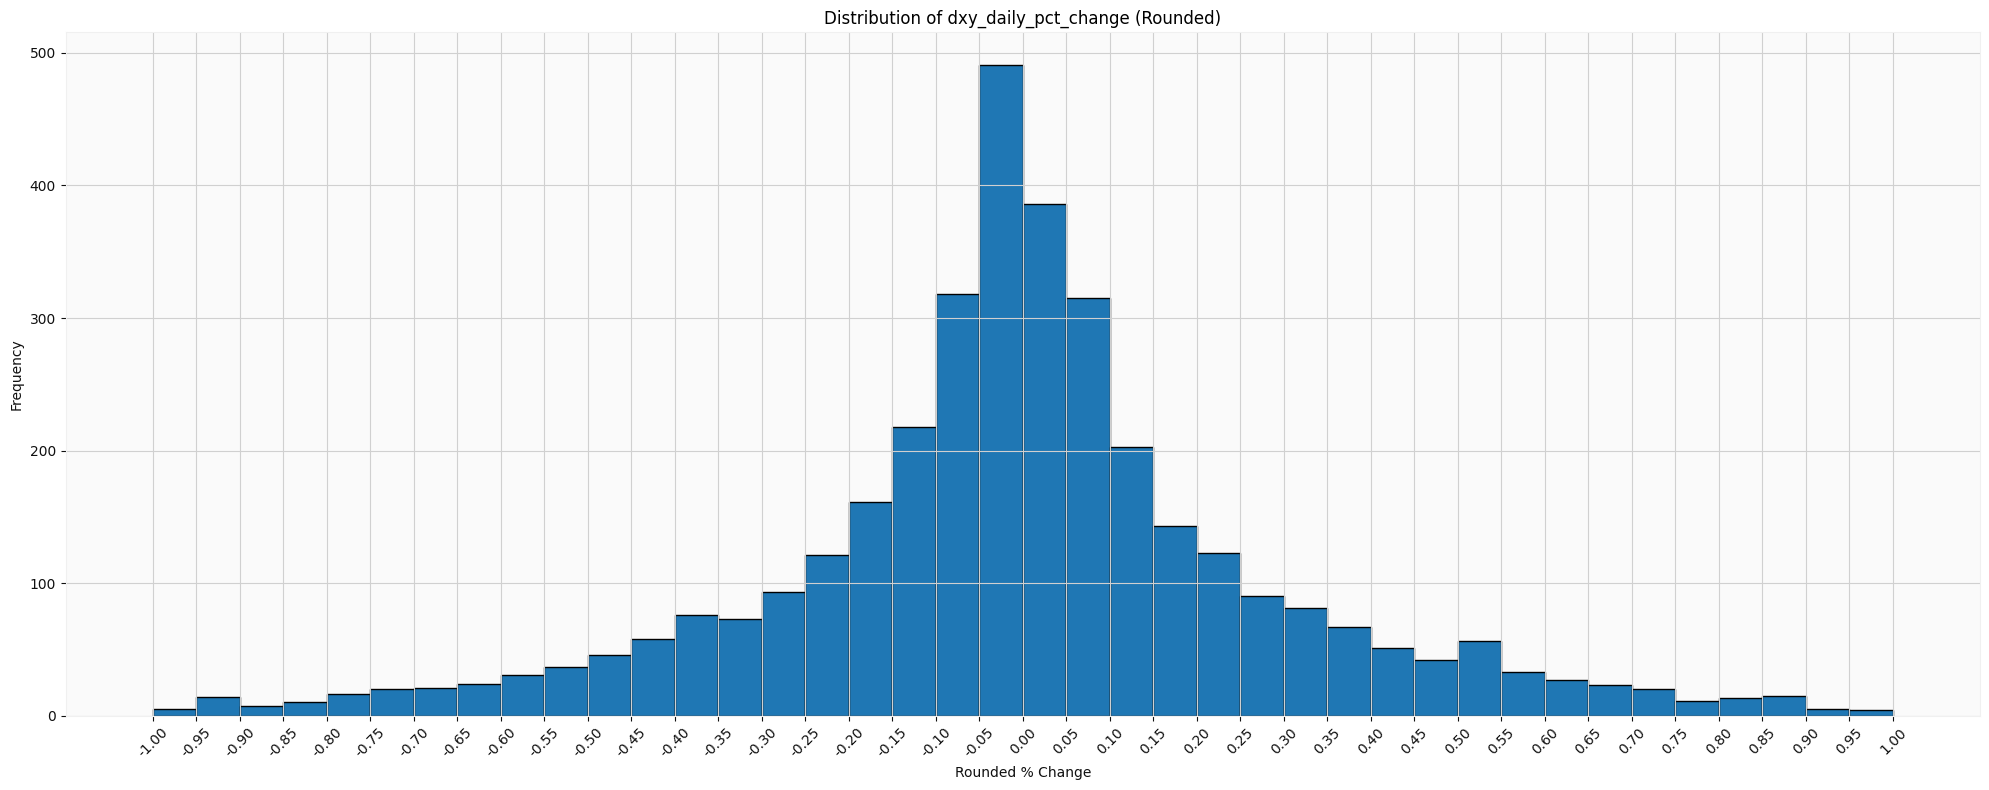

In [131]:
plt.figure(figsize=(20, 8))
# Round the values to two decimal places
df['rounded_pct_change'] = df["dxy_future_pct_change"].round(2)

# Define the bins for intervals (from -1 to 1 with 0.05 intervals)
bins = np.arange(-1, 1.05, 0.05)

# Plot the histogram for visualization
ax = df['rounded_pct_change'].hist(bins=bins, edgecolor='black')

# Set the x-ticks every 0.05, starting from -0.05
x_ticks = np.arange(-1, 1.05, 0.05)
ax.set_xticks(x_ticks)

# Set the x-tick labels to show only the numbers without ranges
ax.set_xticklabels([f'{tick:.2f}' for tick in x_ticks], rotation=45)

# Display the plot
plt.xlabel('Rounded % Change')
plt.ylabel('Frequency')
plt.title('Distribution of dxy_daily_pct_change (Rounded)')

plt.tight_layout()  # Ensures layout is adjusted to avoid clipping
plt.show()

In [265]:
df['Movement'].value_counts()

Movement
Positive    1425
Negative    1385
Stable       843
Name: count, dtype: int64

In [90]:
df.isnull().sum()

DoW                                   0
Month                                 0
Year                                  0
btc_open                              0
btc_high                              0
btc_low                               0
btc_close                             0
oil_open                              0
oil_high                              0
oil_low                               0
oil_close                             0
gold_open                             0
gold_high                             0
gold_low                              0
gold_close                            0
dxy_open                              0
dxy_high                              0
dxy_low                               0
dxy_close                             0
is_holiday                            0
is_weekday                            0
btc_close_weekly_avg                  0
btc_close_monthly_avg                 0
oil_close_weekly_avg                  0
oil_close_monthly_avg                 0


In [266]:
df = df.dropna()  # Drop rows with null values

In [267]:
df = pd.get_dummies(df, columns=['DoW'], drop_first=False)  # One-hot encode 'DoW' column

In [268]:
df = df.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

In [269]:
df.dtypes

Month                                      int64
Year                                       int64
btc_open                                 float64
btc_high                                 float64
btc_low                                  float64
btc_close                                float64
oil_open                                 float64
oil_high                                 float64
oil_low                                  float64
oil_close                                float64
gold_open                                float64
gold_high                                float64
gold_low                                 float64
gold_close                               float64
dxy_open                                 float64
dxy_high                                 float64
dxy_low                                  float64
dxy_close                                float64
is_holiday                                 int64
is_weekday                                 int64
btc_close_weekly_avg

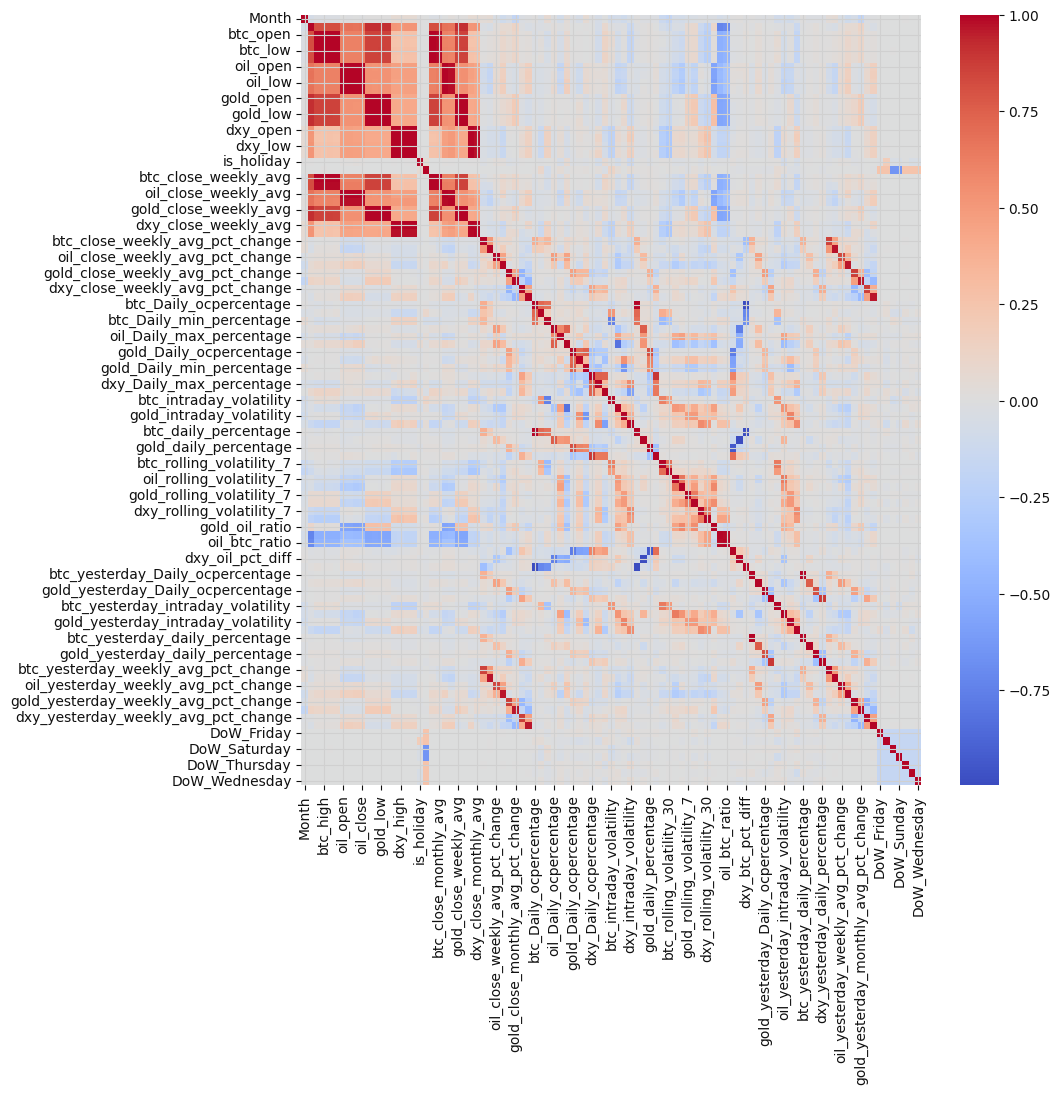

In [270]:
plt.figure(figsize=(10, 10))
corr_matrix = df.drop(columns=['Movement']).corr()

# Plot heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', fmt='.2f')
plt.show()

#### **Feature Selection**
- Checking multicollinearity
- Feature Selection Based on minimizing VIF

In [271]:
# Compute VIF for each feature
data = add_constant(df.drop(columns=['Movement']))

vif_data = pd.DataFrame()
vif_data['feature'] = data.columns
vif_data['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)

/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
97,DoW_Wednesday,inf
69,dxy_oil_pct_diff,inf
92,DoW_Monday,inf
20,is_weekday,inf
95,DoW_Thursday,inf
94,DoW_Sunday,inf
91,DoW_Friday,inf
70,dxy_btc_pct_diff,inf
93,DoW_Saturday,inf
68,dxy_gold_pct_diff,inf


- Removing all Price columns (original columns)
- Removing All DXY related columns. (Movement is the target variable)
- Removing moving averages (keeping percentage  changes)

In [275]:
df_final = df[['Month', 'Year',
#               'btc_open', 'btc_high', 'btc_low', 'btc_close',                                         # Price
#               'oil_open', 'oil_high', 'oil_low', 'oil_close',                                         # Price
#               'gold_open','gold_high', 'gold_low', 'gold_close',                                      # Price
               'dxy_open',# 'dxy_high','dxy_low', 'dxy_close',                                          # Price
                'is_holiday', 
#                'is_weekday',
#               'btc_close_weekly_avg', 'btc_close_monthly_avg',                                        # RA
#               'oil_close_weekly_avg','oil_close_monthly_avg',                                         # RA
#               'gold_close_weekly_avg','gold_close_monthly_avg',                                       # RA
#               'dxy_close_weekly_avg','dxy_close_monthly_avg',                                         # RA
#                'btc_close_weekly_avg_pct_change', 'btc_close_monthly_avg_pct_change',                  # pct_MA
#                'oil_close_weekly_avg_pct_change', 'oil_close_monthly_avg_pct_change',                  # pct_MA
#                'gold_close_weekly_avg_pct_change', 'gold_close_monthly_avg_pct_change',                # pct_MA
#               'dxy_close_weekly_avg_pct_change', 'dxy_close_monthly_avg_pct_change',                  # pct_MA            #DXY
#                'btc_Daily_ocpercentage', 'btc_Daily_max_percentage', 'btc_Daily_min_percentage',       # int_pct
#                'oil_Daily_ocpercentage', 'oil_Daily_max_percentage','oil_Daily_min_percentage',        # int_pct
#                'gold_Daily_ocpercentage','gold_Daily_max_percentage', 'gold_Daily_min_percentage',     # int_pct
#               'dxy_Daily_ocpercentage', 'dxy_Daily_max_percentage', 'dxy_Daily_min_percentage',       # int_pct           #DXY
                'btc_intraday_volatility', 'oil_intraday_volatility', 'gold_intraday_volatility',       # int_vlt
#               'dxy_intraday_volatility',                                                              # int_vlt           #DXY
                'btc_daily_percentage', 'oil_daily_percentage', 'gold_daily_percentage',                # daily_pct
#               'dxy_daily_percentage',                                                                 # daily_pct         #DXY
                'btc_rolling_volatility_7', 'btc_rolling_volatility_30',                                # RA_vlt
                'oil_rolling_volatility_7', 'oil_rolling_volatility_30',                                # RA_vlt
                'gold_rolling_volatility_7', 'gold_rolling_volatility_30',                              # RA_vlt
#               'dxy_rolling_volatility_7', 'dxy_rolling_volatility_30',                                # RA_vlt            #DXY
#                'gold_oil_ratio', 'gold_btc_ratio', 'oil_btc_ratio',                                    # Ratios    
#                'dxy_gold_pct_diff', 'dxy_oil_pct_diff', 'dxy_btc_pct_diff',                            # pct_difference
#               'dxy_future_pct_change', 'rounded_pct_change',                                                              #DXY
#                'btc_yesterday_Daily_ocpercentage', 'oil_yesterday_Daily_ocpercentage','gold_yesterday_Daily_ocpercentage', #yesterday
#                'dxy_yesterday_Daily_ocpercentage',                                                      #yesterday         #DXY                 
                'btc_yesterday_intraday_volatility', 'oil_yesterday_intraday_volatility','gold_yesterday_intraday_volatility',      #yesterday
#                'dxy_yesterday_intraday_volatility',                                                      #yesterday         #DXY
                'btc_yesterday_daily_percentage', 'oil_yesterday_daily_percentage', 'gold_yesterday_daily_percentage',  #yesterday
#                'dxy_yesterday_daily_percentage',                                                      #yesterday         #DXY
                'btc_yesterday_weekly_avg_pct_change', 'btc_yesterday_monthly_avg_pct_change',      #yesterday         #pct_MA
                'oil_yesterday_weekly_avg_pct_change', 'oil_yesterday_monthly_avg_pct_change',        #yesterday     #pct_MA
                'gold_yesterday_weekly_avg_pct_change','gold_yesterday_monthly_avg_pct_change',         #yesterday      #pct_MA
#                'dxy_yesterday_weekly_avg_pct_change', 'dxy_yesterday_monthly_avg_pct_change',          #yesterday         #DXY
                'Movement',                                                                             # target
                'DoW_Friday', 'DoW_Monday', 'DoW_Thursday', 'DoW_Tuesday', 'DoW_Wednesday', 'DoW_Saturday'
#                'DoW_Sunday'
                 ]]

In [276]:
# Compute VIF for each feature
data = add_constant(df_final.drop(columns=['Movement']))

vif_data = pd.DataFrame()
vif_data['feature'] = data.columns
vif_data['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
0,const,745422.356888
11,btc_rolling_volatility_7,3.050794
18,oil_yesterday_intraday_volatility,2.908926
13,oil_rolling_volatility_7,2.615165
14,oil_rolling_volatility_30,2.465138
16,gold_rolling_volatility_30,2.413463
12,btc_rolling_volatility_30,2.262854
6,oil_intraday_volatility,2.108480
17,btc_yesterday_intraday_volatility,1.963988
15,gold_rolling_volatility_7,1.908586


[]

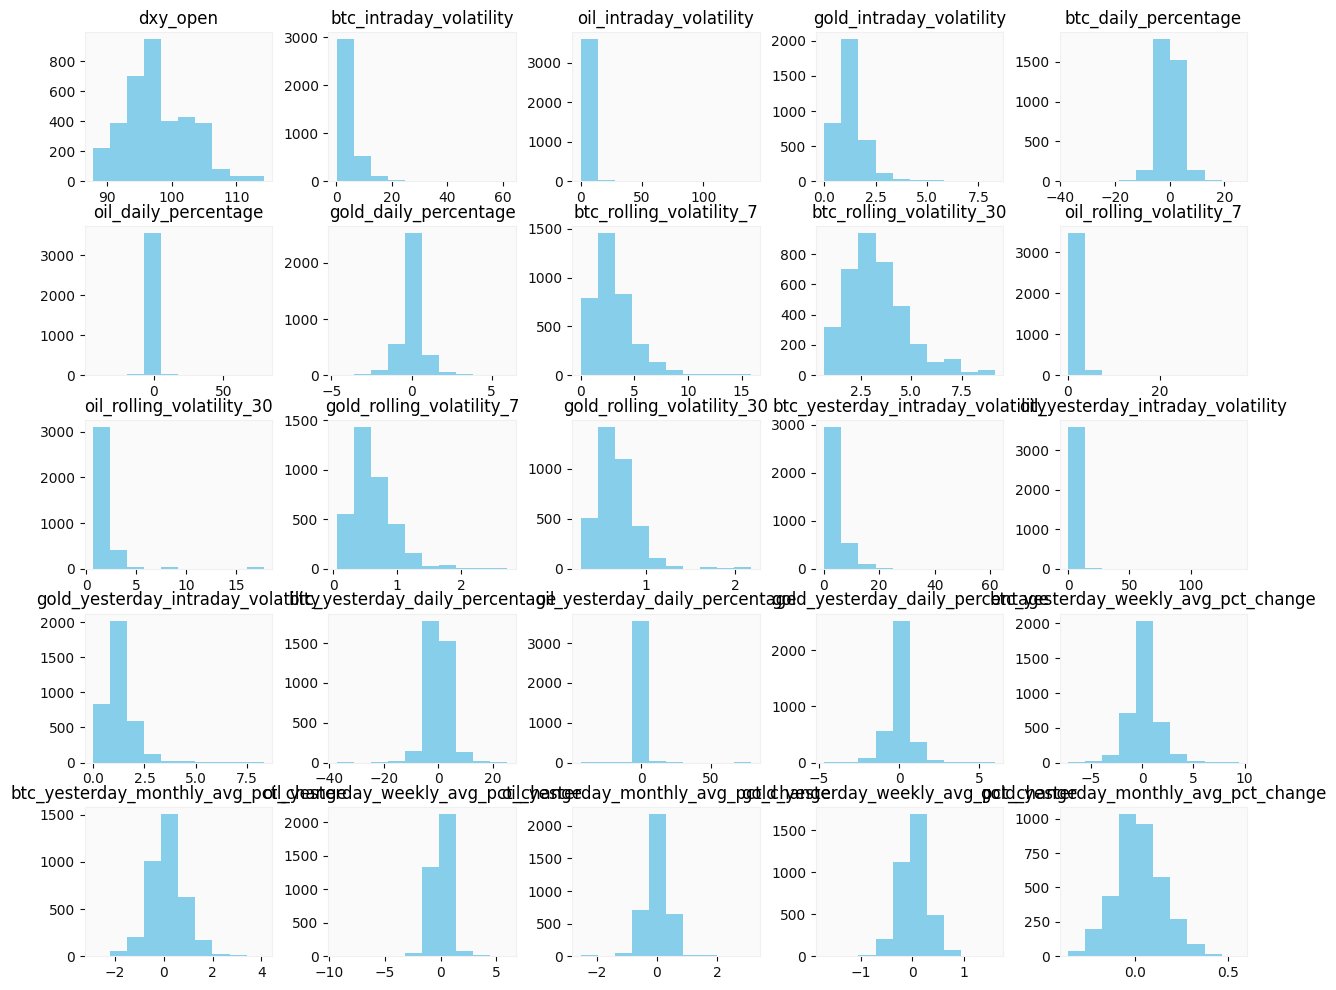

In [277]:
df_final.drop(columns=['Movement','DoW_Friday', 'DoW_Monday', 'DoW_Thursday', 'DoW_Tuesday', 'DoW_Wednesday', 'DoW_Saturday',
                       'Month', 'Year', 'is_holiday']).hist(grid=False, color='skyblue', figsize=(15, 12) )
plt.plot()

#### **Modeling**

In [278]:
# Divide data into X and Y variables
X = df_final.drop(columns=['Movement'])
y = df_final['Movement']

In [279]:
mutual_info_values  = mutual_info_classif(X , y, discrete_features= True )
Columns_to_ = X
mi_df = pd.DataFrame({'Feature': Columns_to_.columns, 'Mutual_Information': mutual_info_values})

mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)

/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/.venv/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/.venv/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/.venv/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/.venv/lib/python3.12/si

In [280]:
mi_df

,Feature,Mutual_Information
23,btc_yesterday_monthly_avg_pct_change,1.073782
17,oil_yesterday_intraday_volatility,1.073782
12,oil_rolling_volatility_7,1.073782
25,oil_yesterday_monthly_avg_pct_change,1.073782
15,gold_rolling_volatility_30,1.073782
14,gold_rolling_volatility_7,1.073782
27,gold_yesterday_monthly_avg_pct_change,1.073782
13,oil_rolling_volatility_30,1.073782
11,btc_rolling_volatility_30,1.073782
5,oil_intraday_volatility,1.073399


In [289]:
# # Time split
# tscv = TimeSeriesSplit(n_splits=5)


In [297]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True,random_state=123)

In [296]:
# Time series modeling

# fi_smote_df = pd.DataFrame(columns=['Model_name', 'Accuracy', 'Precision', 'Recall', 'F1_Score'])

# # Iterate over each train-test split and evaluate
# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     # Preprocess data
#     X_train_preprocessed = preprocessor.fit_transform(X_train)
#     X_test_preprocessed = preprocessor.transform(X_test)
    
#     # Encode the target variable
#     label_encoder = LabelEncoder()
#     y_train_encoded = label_encoder.fit_transform(y_train)
#     y_test_encoded = label_encoder.transform(y_test)

#     # Train and evaluate each model
#     for model_name, classifier in models:
#         classifier.fit(X_train_preprocessed, y_train_encoded)
#         y_pred = classifier.predict(X_test_preprocessed)
        
#         # Generate and collect performance metrics
#         report = classification_report(y_test_encoded, y_pred, output_dict=True)
#         fi_smote_df.loc[len(fi_smote_df)] = [
#             model_name,
#             report['accuracy'],
#             report['weighted avg']['precision'],
#             report['weighted avg']['recall'],
#             report['weighted avg']['f1-score']
#         ]

# # Initialize a DataFrame to store aggregated results
# aggregated_results = fi_smote_df.groupby("Model_name").mean().reset_index()

# # Sort the results by Accuracy (or any other metric) in descending order
# aggregated_results = aggregated_results.sort_values(by="Accuracy", ascending=False)

# # Display the aggregated results
# print(aggregated_results)

             Model_name  Accuracy  Precision    Recall  F1_Score
2              CatBoost  0.531675   0.538407  0.531675  0.521201
14    Voting Classifier  0.531012   0.541752  0.531012  0.522932
11        Random Forest  0.528690   0.541741  0.528690  0.513036
7              LightGBM  0.520066   0.529617  0.520066  0.514140
5     Gradient Boosting  0.516418   0.523362  0.516418  0.510273
12                  SVC  0.513765   0.536790  0.513765  0.498446
0              AdaBoost  0.510116   0.512297  0.510116  0.503774
4           Extra Trees  0.508126   0.523135  0.508126  0.498397
15              XGBoost  0.507131   0.517511  0.507131  0.499191
13  Stacking Classifier  0.494196   0.477552  0.494196  0.446671
8   Logistic Regression  0.482919   0.516128  0.482919  0.471796
1    Bagging Classifier  0.474295   0.475658  0.474295  0.464680
9           Naive Bayes  0.452405   0.491697  0.452405  0.427048
10       Neural Network  0.441128   0.469590  0.441128  0.437450
6                   KNN  

In [298]:
y_train.value_counts()

Movement
Positive    1114
Negative    1098
Stable       684
Name: count, dtype: int64

In [299]:
y_test.value_counts()

Movement
Positive    298
Negative    272
Stable      155
Name: count, dtype: int64

In [300]:
input_features = X.columns
input_features

Index(['Month', 'Year', 'dxy_open', 'is_holiday', 'btc_intraday_volatility',
       'oil_intraday_volatility', 'gold_intraday_volatility',
       'btc_daily_percentage', 'oil_daily_percentage', 'gold_daily_percentage',
       'btc_rolling_volatility_7', 'btc_rolling_volatility_30',
       'oil_rolling_volatility_7', 'oil_rolling_volatility_30',
       'gold_rolling_volatility_7', 'gold_rolling_volatility_30',
       'btc_yesterday_intraday_volatility',
       'oil_yesterday_intraday_volatility',
       'gold_yesterday_intraday_volatility', 'btc_yesterday_daily_percentage',
       'oil_yesterday_daily_percentage', 'gold_yesterday_daily_percentage',
       'btc_yesterday_weekly_avg_pct_change',
       'btc_yesterday_monthly_avg_pct_change',
       'oil_yesterday_weekly_avg_pct_change',
       'oil_yesterday_monthly_avg_pct_change',
       'gold_yesterday_weekly_avg_pct_change',
       'gold_yesterday_monthly_avg_pct_change', 'DoW_Friday', 'DoW_Monday',
       'DoW_Thursday', 'DoW_Tuesday

In [301]:
input_pipeline = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
])


preprocessor = ColumnTransformer(transformers=[
    ('numerical_pipeline', input_pipeline, input_features),
    ])

In [302]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [320]:
models = [
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('SVC', SVC(random_state=42, probability=True)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('Bagging Classifier', BaggingClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
    ('LightGBM', LGBMClassifier(random_state=42)),
    ('Naive Bayes', GaussianNB()),
    ('KNN', KNeighborsClassifier()),
    ('Extra Trees', ExtraTreesClassifier(random_state=42)),
    ('Neural Network', MLPClassifier(random_state=42, max_iter=500))
]

In [321]:
# Create an ensemble model using majority voting (or weighted voting if you prefer)
voting_estimators = [
     ('Random Forest', RandomForestClassifier(random_state=42)),
     ('Logistic Regression', LogisticRegression(random_state=42)),
     ('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
     ('SVC', SVC(probability=True, random_state=42)),   
     ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
     ('LightGBM', LGBMClassifier(random_state=42)),
]

ensemble_model = VotingClassifier(estimators=voting_estimators, voting='soft')

# Add ensemble model to the models list
models.append(('Voting Classifier', ensemble_model))

In [322]:
# Create an ensemble stacking classifier
base_learners = [
    # ('Random Forest', RandomForestClassifier(random_state=42)),  
    ('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),  # verbose=0 to keep output clean
    ('LightGBM', LGBMClassifier(random_state=42))
    # ('SVC', SVC(probability=True, random_state=42))  
]

# Set Logistic Regression as the meta learner
meta_learner = SVC(probability=True, random_state=42)

# Configure the StackingClassifier
stacking_classifier = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# Assuming 'models' is a list meant to store different models for further evaluation
models.append(('Stacking Classifier', stacking_classifier))

In [323]:
selection = SelectKBest(mutual_info_classif, k='all')

fi_smote_df = pd.DataFrame(columns=['Model_name', 'Accuracy', 'Precision', 'Recall', 'F1_Score'])

all_pipelines = {}

for model_name, classifier in models:

    pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_importance', selection),
    ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train_encoded)

    all_pipelines[model_name] = pipeline

    smote_y_pred = pipeline.predict(X_test)

    fi_smote_dict = classification_report(y_test_encoded, smote_y_pred, output_dict=True)

    accuracy = fi_smote_dict['accuracy']
    precision = fi_smote_dict['weighted avg']['precision']
    recall = fi_smote_dict['weighted avg']['recall']
    f1_score = fi_smote_dict['weighted avg']['f1-score']

    fi_smote_df.loc[len(fi_smote_df)] = [model_name, accuracy, precision, recall, f1_score]


fi_smote_df.sort_values(by='Accuracy', ascending=False)

/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6412
[LightGBM] [Info] Number of data points in the train set: 2896, number of used features: 34
[LightGBM] [Info] Start training from score -0.969840
[LightGBM] [Info] Start training from score -0.955373
[LightGBM] [Info] Start training from score -1.443128


/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/.venv/lib/python3.12/site-packages/xgboost/training.py:181: UserWarning: [21:26:19] WARNING: /private/var/folders/by/fqpfnqw528347myb5cyy33x80000gn/T/build-via-sdist-o0amlavf/xgboost-2.2.0.dev0/cpp_src/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6412
[LightGBM] [Info] Number of data points in the train set: 2896, number of used features: 34
[LightGBM] [Info] Start training from score -0.969840
[LightGBM] [Info] Start training from score -0.955373
[LightGBM] [Info] Start training from score -1.443128


/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/.venv/lib/python3.12/site-packages/xgboost/training.py:181: UserWarning: [21:26:24] WARNING: /private/var/folders/by/fqpfnqw528347myb5cyy33x80000gn/T/build-via-sdist-o0amlavf/xgboost-2.2.0.dev0/cpp_src/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6412
[LightGBM] [Info] Number of data points in the train set: 2896, number of used features: 34
[LightGBM] [Info] Start training from score -0.969840
[LightGBM] [Info] Start training from score -0.955373
[LightGBM] [Info] Start training from score -1.443128


/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/.venv/lib/python3.12/site-packages/xgboost/training.py:181: UserWarning: [21:26:29] WARNING: /private/var/folders/by/fqpfnqw528347myb5cyy33x80000gn/T/build-via-sdist-o0amlavf/xgboost-2.2.0.dev0/cpp_src/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/.venv/lib/python3.12/site-packages/xgboost/training.py:181: UserWarning: [21:26:30] WARNING: /private/var/folders/by/fqpfnqw528347myb5cyy33x80000gn/T/build-via-sdist-o0amlavf/xgboost-2.2.0.dev0/cpp_src/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/.venv/lib/python3.12/site-packages/xgboost/training.py:181: UserWarning: [21:26:31] WARNING: /private/var/folders/by/fqpfnqw528347myb5cyy33x80000gn/T/build-via-sdist-o0amlavf/xgb

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6412
[LightGBM] [Info] Number of data points in the train set: 2316, number of used features: 34
[LightGBM] [Info] Start training from score -0.969950
[LightGBM] [Info] Start training from score -0.955252
[LightGBM] [Info] Start training from score -1.443148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6412
[LightGBM] [Info] Number of data points in the train set: 2317, number of used features: 34
[LightGBM] [Info] Start training from score -0.970382
[LightGBM] [Info] Start training from score -0.955684
[LightGBM] [Info] Start training from score -1.441753
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 secon

,Model_name,Accuracy,Precision,Recall,F1_Score
15,Stacking Classifier,0.711724,0.712621,0.711724,0.711017
4,XGBoost,0.702069,0.703316,0.702069,0.702079
14,Voting Classifier,0.696552,0.698968,0.696552,0.695435
8,CatBoost,0.695172,0.695239,0.695172,0.694545
9,LightGBM,0.668966,0.670533,0.668966,0.668345
2,Random Forest,0.664828,0.674109,0.664828,0.662595
12,Extra Trees,0.659310,0.664774,0.659310,0.659241
5,Bagging Classifier,0.626207,0.637697,0.626207,0.623639
7,Gradient Boosting,0.601379,0.601576,0.601379,0.597563
1,SVC,0.571034,0.569705,0.571034,0.568095


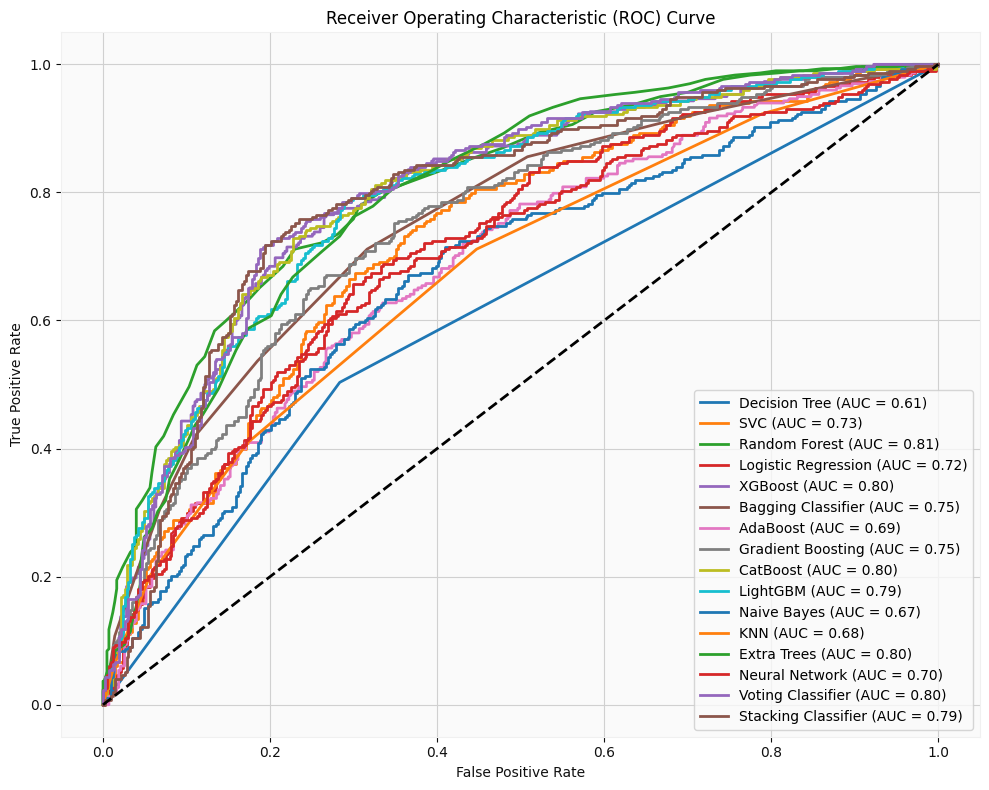

In [324]:
# Initialize the figure
plt.figure(figsize=(10, 8))

# Loop through each model and plot its ROC curve
for model_name, pipeline in all_pipelines.items():
    # Predict probabilities for the positive class (Class 1)
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test_encoded, y_prob, pos_label=1)  # Positive class = 1
    roc_auc = auc(fpr, tpr)  # Calculate AUC
    
    # Plot the ROC curve for each model
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (Random classifier line)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()

In [325]:
catboost_pipeline = all_pipelines['CatBoost']
catboost_smote_y_pred = catboost_pipeline.predict(X_test)
catboost_model = catboost_pipeline.named_steps['classifier']

In [326]:
XGBoost_pipeline = all_pipelines['XGBoost']
XGBoost_smote_y_pred = XGBoost_pipeline.predict(X_test)
XGBoost_model = XGBoost_pipeline.named_steps['classifier']

In [327]:
voting_pipeline = all_pipelines['Voting Classifier']
voting_smote_y_pred = voting_pipeline.predict(X_test)
voting_model = voting_pipeline.named_steps['classifier']

In [328]:
stacking_pipeline = all_pipelines['Stacking Classifier']
stacking_smote_y_pred = stacking_pipeline.predict(X_test)
stacking_model = stacking_pipeline.named_steps['classifier']

In [329]:
print(label_encoder.classes_)  # Shows the class names in order of their indices
print(catboost_model.classes_)  # For models that expose class labels

['Negative' 'Positive' 'Stable']
[0 1 2]


#### Confusion Matrices of 4 top models

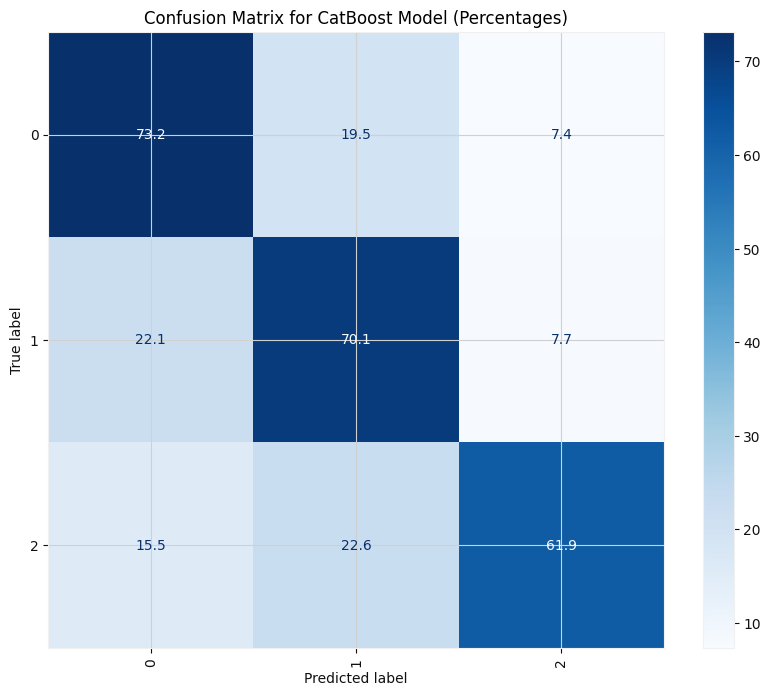

In [330]:
cm = confusion_matrix(y_test_encoded, catboost_smote_y_pred)
# Calculate the percentage for each element in the confusion matrix
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Display confusion matrix with percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, 
                              display_labels=catboost_pipeline.named_steps['classifier'].classes_)

# Use the 'Blues' colormap and rotate the x-ticks for better visibility
disp.plot(cmap='Blues', xticks_rotation='vertical', values_format='.1f')  # Format with 1 decimal place
plt.gcf().set_size_inches(10, 8)  # Increase figure size
plt.title("Confusion Matrix for CatBoost Model (Percentages)")
plt.show()

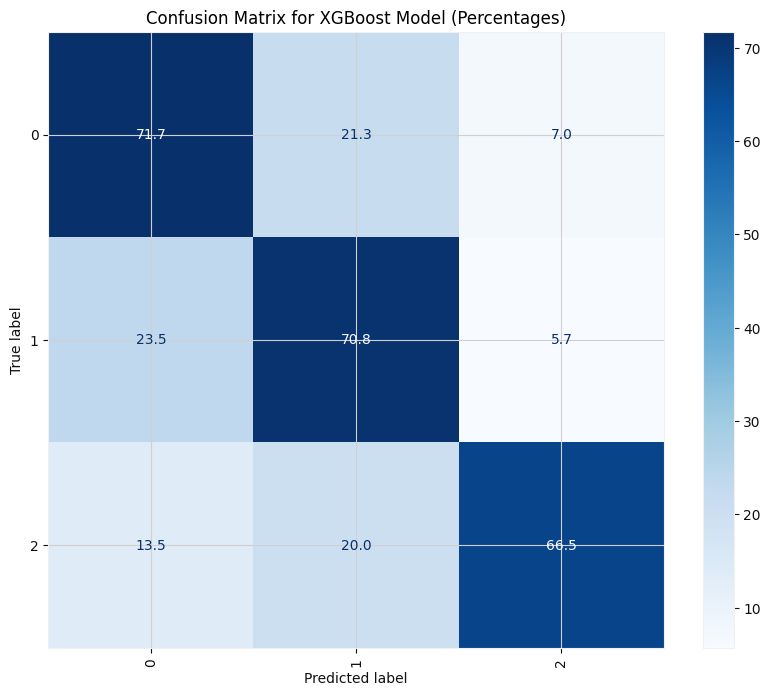

In [332]:
cm = confusion_matrix(y_test_encoded, XGBoost_smote_y_pred)
# Calculate the percentage for each element in the confusion matrix
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Display confusion matrix with percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, 
                              display_labels=XGBoost_pipeline.named_steps['classifier'].classes_)

# Use the 'Blues' colormap and rotate the x-ticks for better visibility
disp.plot(cmap='Blues', xticks_rotation='vertical', values_format='.1f')  # Format with 1 decimal place
plt.gcf().set_size_inches(10, 8)  # Increase figure size
plt.title("Confusion Matrix for XGBoost Model (Percentages)")
plt.show()

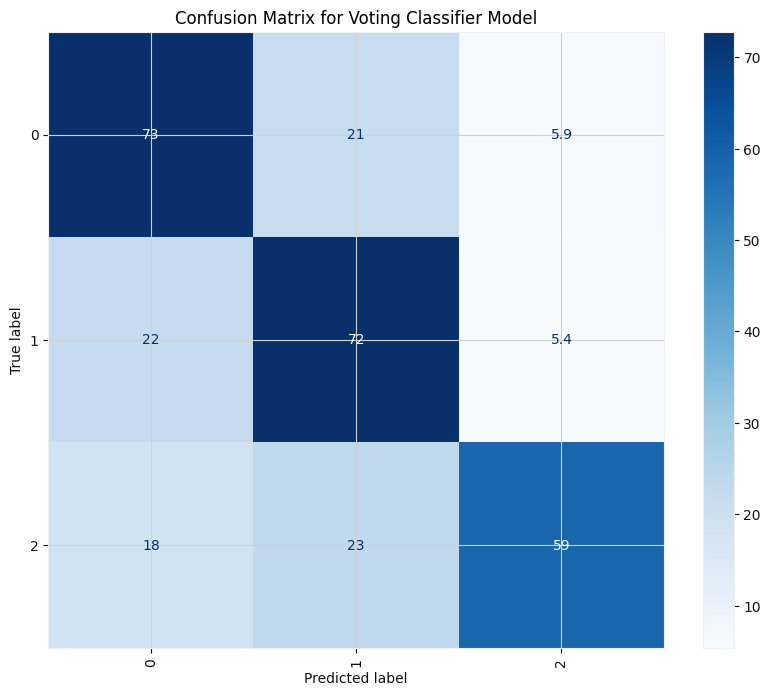

In [333]:
cm = confusion_matrix(y_test_encoded, voting_smote_y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=voting_pipeline.named_steps['classifier'].classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.gcf().set_size_inches(10, 8)  # Increase figure size
plt.title("Confusion Matrix for Voting Classifier Model")
plt.show()

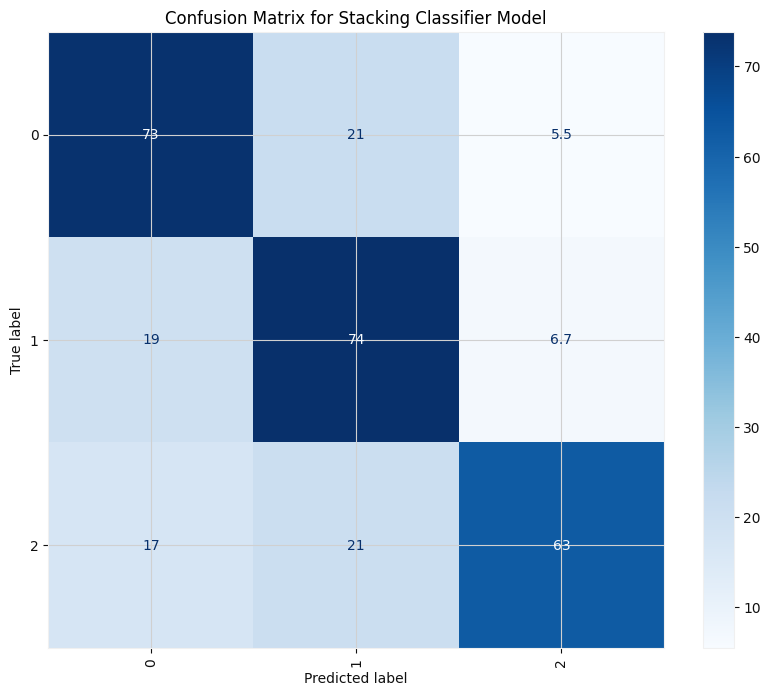

In [334]:
cm = confusion_matrix(y_test_encoded, stacking_smote_y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=stacking_pipeline.named_steps['classifier'].classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.gcf().set_size_inches(10, 8)  # Increase figure size
plt.title("Confusion Matrix for Stacking Classifier Model")
plt.show()

#### Feature importance of 4 top models

In [336]:
## XGBoost
# Get feature importance
feature_importances = XGBoost_pipeline.named_steps['classifier'].feature_importances_

feature_names = []
for transformer in preprocessor.transformers_:
    trans_name, transformer, col_names = transformer
    # Handle cases for pipelines within column transformers or directly applied transformers
    if hasattr(transformer, 'get_feature_names_out'):
        # For transformers that generate multiple column names (e.g., OneHotEncoder)
        feature_names.extend(transformer.get_feature_names_out(col_names))
    else:
        # For transformers that do not change the number of features (e.g., StandardScaler)
        feature_names.extend(col_names)

# Create a DataFrame for feature importances
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(fi_df)

                                  Feature  Importance
3                              is_holiday    0.095700
29                             DoW_Monday    0.087227
33                           DoW_Saturday    0.084821
9                   gold_daily_percentage    0.050188
5                 oil_intraday_volatility    0.032148
31                            DoW_Tuesday    0.030756
1                                    Year    0.030044
32                          DoW_Wednesday    0.027997
28                             DoW_Friday    0.027110
30                           DoW_Thursday    0.026721
8                    oil_daily_percentage    0.025063
14              gold_rolling_volatility_7    0.023422
13              oil_rolling_volatility_30    0.023404
26   gold_yesterday_weekly_avg_pct_change    0.023010
12               oil_rolling_volatility_7    0.022741
17      oil_yesterday_intraday_volatility    0.022659
2                                dxy_open    0.022514
22    btc_yesterday_weekly_a

In [337]:
# Catboost
# Get feature importance from the CatBoost model
feature_importances = catboost_model.get_feature_importance()

# Retrieve feature names from the preprocessing pipeline
feature_names = []
for transformer in preprocessor.transformers_:
    trans_name, transformer, col_names = transformer
    # Handle cases for pipelines within column transformers or directly applied transformers
    if hasattr(transformer, 'get_feature_names_out'):
        feature_names.extend(transformer.get_feature_names_out(col_names))
    else:
        feature_names.extend(col_names)

# Create a DataFrame for feature importances
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importances
print(fi_df)

                                  Feature  Importance
9                   gold_daily_percentage   10.443910
8                    oil_daily_percentage    5.862335
14              gold_rolling_volatility_7    4.333257
5                 oil_intraday_volatility    4.040549
26   gold_yesterday_weekly_avg_pct_change    4.034372
24    oil_yesterday_weekly_avg_pct_change    3.683066
18     gold_yesterday_intraday_volatility    3.583393
15             gold_rolling_volatility_30    3.466653
6                gold_intraday_volatility    3.414642
23   btc_yesterday_monthly_avg_pct_change    3.388956
21        gold_yesterday_daily_percentage    3.369568
12               oil_rolling_volatility_7    3.361539
27  gold_yesterday_monthly_avg_pct_change    3.327264
11              btc_rolling_volatility_30    3.324000
25   oil_yesterday_monthly_avg_pct_change    3.322743
2                                dxy_open    3.234123
13              oil_rolling_volatility_30    3.145866
17      oil_yesterday_intrad

In [349]:
from joblib import dump, load

# Saving the model
dump(stacking_classifier, 'stacking_classifier.joblib')

['stacking_classifier.joblib']

In [ ]:
# Saving the model
dump(stacking_classifier, 'stacking_classifier.joblib')